# Basic Machine Learning for Predicting Thunderstorm Rotation

This module uses basic ML models &ndash; linear regression, logistic regression, decision trees, random forests, and gradient-boosted trees &ndash; to predict future rotation in numerically simulated thunderstorms from the National Center for Atmospheric Research (NCAR) convection-allowing ensemble (Schwartz *et al.* 2015).

# References

This notebook refers to a few publications, listed below.

Chisholm, D., J. Ball, K. Veigas, and P. Luty, 1968: "The diagnosis of upper-level humidity." *Journal of Applied Meteorology*, **7 (4)**, 613-619.

Hsu, W., and A. Murphy, 1986: "The attributes diagram: A geometrical framework for assessing the quality of probability forecasts." *International Journal of Forecasting*, **2**, 285–293, https://doi.org/10.1016/0169-2070(86)90048-8.

McGovern, A., D. Gagne II, J. Basara, T. Hamill, and D. Margolin, 2015: "Solar energy prediction: An international contest to initiate interdisciplinary research on compelling meteorological problems." *Bulletin of the American Meteorological Society*, **96 (8)**, 1388-1395.

Metz, C., 1978: "Basic principles of ROC analysis." *Seminars in Nuclear Medicine*, **8**, 283–298, https://doi.org/10.1016/S0001-2998(78)80014-2.

Quinlan, J., 1986: "Induction of decision trees." *Machine Learning*, **1 (1)**, 81–106.

Roebber, P., 2009: "Visualizing multiple measures of forecast quality." *Weather and Forecasting*, **24**, 601-608, https://doi.org/10.1175/2008WAF2222159.1.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181.

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the commands `pip install scipy`, `pip install tensorflow`, etc.

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
%matplotlib inline
import copy
import warnings
import numpy
import matplotlib.pyplot as pyplot
import utils

warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

MODULE2_DIR_NAME = '.'
SHORT_COURSE_DIR_NAME = '..'

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Overfitting

 - You can't talk about machine learning without talking about overfitting.
 - Overfitting occurs when the model performs well on training data but does not generalize well to new data.
 - This usually occurs in the following scenarios:
     - **Training set is small**.
     - Training set includes **inappropriate predictors**.
     - Training set is **not representative of the real world**.
<br><br>
 - **Examples of inappropriate predictors**:
     - Using storm ID to predict tornadoes.
     - Using patient ID to predict disease.
     - In general, using variables with no physical relationship to the target phenomenon.
<br><br>
 - **Examples of non-representative training data**:
     - Different label distributions (*e.g.*, training set contains 50% tornadic storms, but in the real world $<$ 1% of storms are tornadic).
     - Different levels of data quality (*e.g.*, training on archived radar data but applying to real-time data).
<br><br>

 - You can **mitigate** overfitting by not making these mistakes.
 - However, these properties (appropriateness of predictor, representativity of training data, etc.) are not always clear.
 - Also, many other things can lead to overfitting.
 - Thus, you also need the ability to **diagnose** overfitting.
 - This is usually done by splitting data into 3 partitions: training, validation, and testing.

# Training, Validation, and Testing

 - **Role of training data:** train the model (*e.g.*, adjust weights in linear regression or neural net, adjust decision boundaries in decision tree).
 - **Role of validation data:** choose the best hyperparameters (parameters not adjusted by training).
     - *e.g.*, learning rate, number of iterations, number of layers in a neural net
<br><br>
 - **Role of testing data:** evaluate the selected model on independent data.
     - The selected model is the one that performs best on validation data.
     - There are many ways to define "best" (lowest mean squared error, lowest cross-entropy, highest area under ROC curve, etc.).
<br><br>

 - Training, validation, and testing (TV&T) sets should be **statistically independent**.
 - **For example, in disease prediction:**
     - If there are multiple tissue scans from the same patient, they should all be in the same set.
     - Multiple patients in the same family should also be in the same set.
<br><br>
 - **In storm-hazard prediction:**
     - If there are multiple radar scans from the same storm, they should all be in the same set.
     - Related storms (*e.g.*, part of the same MCS) should also be in the same set.
<br><br>
 - **In weather prediction generally:**
     - Data should be free of temporal autocorrelation.
     - For storm-scale phenomena, it is probably sufficient to leave a one-day gap between each pair of datasets.
     - For synoptic-scale phenomena, you may need a one-week gap between each pair of datasets.<br><br>
     - If training on one area and applying to a different area, data should be free of spatial autocorrelation.
     - For example, say you are training on a model on North America but applying in real-time to Africa.
     - TV&T sets should contain spatially non-overlapping parts of North America.
     - When you test on a part of North America that has not been used to train/validate the model, hopefully this gives you a reasonable estimation of performance in Africa, which also has not been used to train/validate the model.

# Find Input Files

The next cell finds input files for the training (2010-14), validation (2015), and testing (2016-17) periods.

In [3]:
training_file_names = utils.find_many_feature_files(
    first_date_string='20100101', last_date_string='20141231')

validation_file_names = utils.find_many_feature_files(
    first_date_string='20150101', last_date_string='20151231')

testing_file_names = utils.find_many_feature_files(
    first_date_string='20160101', last_date_string='20171231')

# Read Data

The next cell reads training, validation, and testing data &ndash; and explores the contents of one file.

In [4]:
(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_feature_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_feature_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_feature_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20151227-0000.csv"...


--------------------------------------------------


Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160224-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160323-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160401-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160415-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160429-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160505-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160511-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_

# Normalization

 - When you have multiple predictor variables on different scales, they should be normalized.
 - This ensures that the model does not ignore variables with smaller scales.
 - For example, if a model is trained with temperature in Kelvins and specific humidity in kg kg$^{-1}$, it will probably learn to emphasize temperature (which varies from $\sim$180-330 K) and ignore specific humidity (which varies from $\sim$0-0.02 kg kg$^{-1}$).
<br><br>
 - The most common normalization method is $z$-scores.
 - Each predictor variable is transformed independently to $z$-scores, using the mean and standard deviation from the training data.
 - Validation and testing data should also be normalized, but using the means and standard deviations from the training data.
<br><br>
 - **Question:** why is it a bad idea to use the validation/testing data to compute means and standard deviations (or any other data-processing parameters)?

# Normalization Code

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation) for each predictor, based only on the training data.
 - Normalizes the training, validation, and testing data, using these normalization params.
 - Denormalizes the training data and ensures that denormalized values = original values (sanity check).

In [5]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict)

Original values of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "REFL_COM_mean" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


# Linear Regression

Linear regression fits the following equation to the training data.

$\hat{y} = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$

 - $x_j$ = $j^{\textrm{th}}$ predictor variable
 - $\beta_j$ = coefficient for $j^{\textrm{th}}$ predictor variable (adjusted during training)
 - $M$ = number of predictor variables
 - $\beta_0$ = bias coefficient or "intercept" (adjusted during training)
 - $\hat{y}$ = prediction for target variable (in this case, max future vorticity within storm, in s$^{-1}$)
<br><br>
The weights ($\beta_0$ and $\beta_j$) are trained to minimize the mean squared error (MSE).<br>
This is why linear regression is often called "least-squares linear regression".

$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$

 - $y_i$ = actual target value for $i^{\textrm{th}}$ example (in this case, one example is one storm cell at one time, or one "storm object")
 - $\hat{y}_i$ = predicted target value for $i^{\textrm{th}}$ example
 - $N$ = number of training examples

Combining the two equations yields the following, where $x_{ij}$ is the $j^{\textrm{th}}$ predictor for the $i^{\textrm{th}}$ example.

$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_{ij} - y_i)^2$

The derivatives of model coefficients with respect to MSE are as follows.

$\frac{\partial}{\partial \beta_0}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
<br>
$\frac{\partial}{\partial \beta_j}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} x_{ij} (\hat{y}_i - y_i)$

During training, the weights ($\beta_0$ and $\beta_j$) are adjusted over many iterations.<br>
After each iteration, the "gradient-descent rule" (shown below) is applied, where $\alpha \in \left(0, 1\right]$ is the learning rate.

$\beta_0 \leftarrow \beta_0 - \alpha \frac{\partial}{\partial \beta_0}(\textrm{MSE})$
<br>
$\beta_j \leftarrow \beta_j - \alpha \frac{\partial}{\partial \beta_j}(\textrm{MSE})$

# Linear Regression: Example

**The next cell does the following:**

 - Trains a linear-regression model (with default hyperparameters) to predict max future rotation in each storm.
 - Evaluates the model on both training and validation data.

**For both training and validation data, this cell reports the following quantities:**

 - Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$
 - Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$
 - Mean signed error ("bias"): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
 - MAE skill score.  This is defined as follows, where MAE is the MAE of the model and $\textrm{MAE}_{\textrm{climo}}$ is the MAE obtained by always predicting "climatology" (the average in the training data).

$\textrm{MAE skill score} = \frac{\textrm{MAE}_{\textrm{climo}} - \textrm{MAE}}{\textrm{MAE}_{\textrm{climo}}}$

 - MSE skill score, defined as follows.

$\textrm{MSE skill score} = \frac{\textrm{MSE}_{\textrm{climo}} - \textrm{MSE}}{\textrm{MSE}_{\textrm{climo}}}$

Finally, this cell plots a **reliability curve**, which shows the conditional mean observation for each forecast value.  This allows you to identify conditional bias (bias that occurs for certain forecast values).

Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 1.817e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


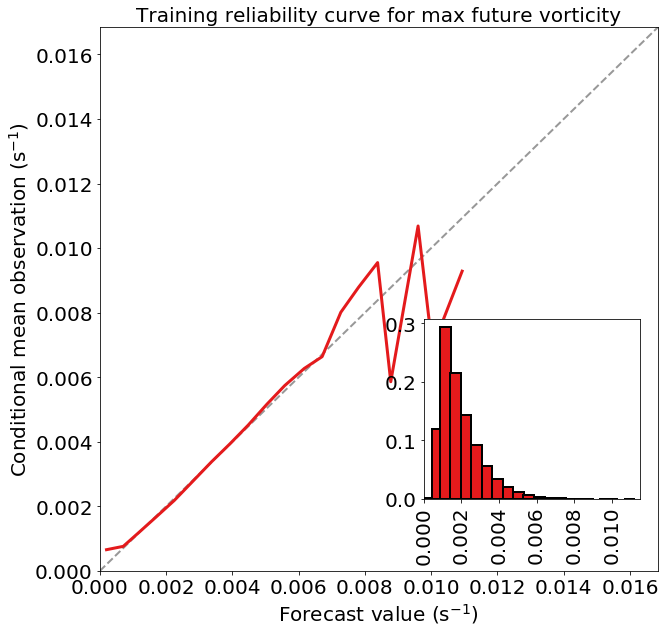



--------------------------------------------------


Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.048e-06 s^-2
Validation bias (mean signed error) = -9.007e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


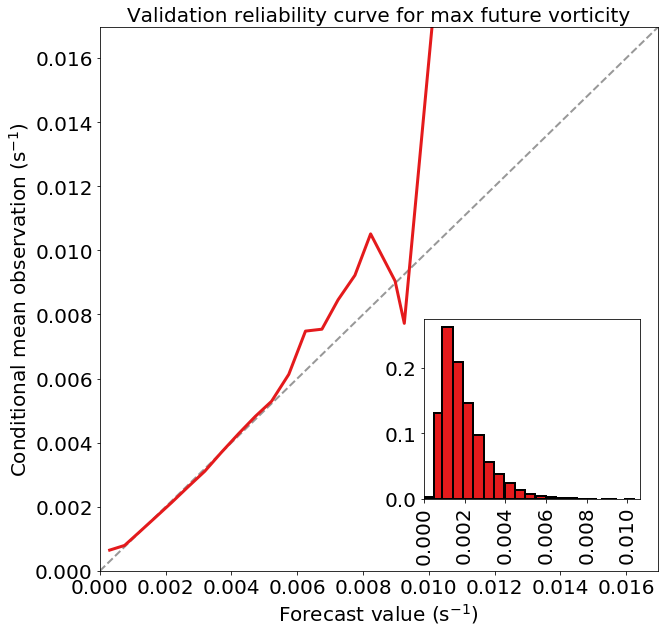

In [6]:
linreg_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=0.)

_ = utils.train_linear_regression(
    model_object=linreg_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linreg_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linreg_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

# Linear Regression: Coefficients

The next cell plots coefficients for the linear-regression model.  If predictor $x_j$ has a positive (negative) coefficient, the prediction increases (decreases) with $x_j$.
<br><br>
Keep in mind that all predictors have been normalized to the same scale ($z$-scores), so generally predictors with larger coefficients are more important.
<br><br>
Also, note that every predictor is used (has a non-zero coefficient).

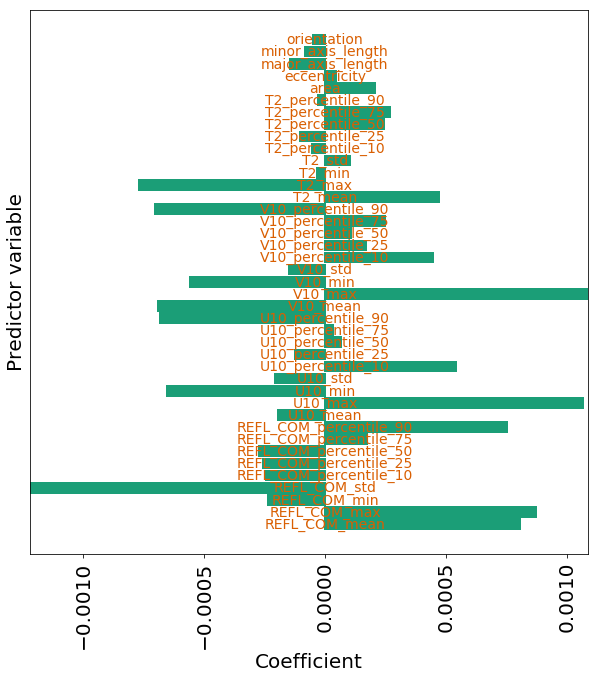

In [15]:
utils.plot_model_coefficients(
    model_object=linreg_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# $L_1$ and $L_2$ Regularization

 - In general, regularization is a way to prevent overfitting by creating a simpler model.
 - $L_1$ and $L_2$ regularization encourage the model to have smaller coefficients.
<br><br>
 - This is useful when there are many predictors, because it is likely that some of these predictors have a weak causal relationship with the phenomenon.
 - Without regularization the model will try to incorporate every predictor, which may lead to overfitting peculiarities of the training data.
 - Regularization encourages the model to learn large coefficients for only a small number of predictors (the **really** important ones).
<br><br>
 - $L_1$ and $L_2$ regularization encourage smaller coefficients by adding **penalties** to the loss function.
 - For linear regression, the loss function turns into the following.

$\epsilon = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2 + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2 = \textrm{MSE} + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$

 - The first term is just MSE (mean squared error).
 - The second term is the $L_1$ penalty.  $\lambda_1$ is the strength of the $L_1$ penalty, and $\sum\limits_{j = 1}^{M} \lvert \beta_j \rvert$ is the sum of absolute coefficient values.
 - The third term is the $L_2$ penalty.  $\lambda_2$ is the strength of the $L_2$ penalty, and $\lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$ is the sum of squared coefficient values.
<br><br>
 - Both penalties encourage smaller coefficients, but the $L_1$ penalty also encourages fewer non-zero coefficients.
 - This is because the $L_1$ penalty does not square coefficient values.
 - For small coefficient values the $L_2$ penalty becomes negligible unless $L_2$ is very large.  For example, squaring a coefficient of $10^{-3}$ yields $10^{-6}$, and this penalty is usually negligible.
<br><br>
 - For this reason the $L_1$ penalty is called the "lasso penalty" (it throws a lasso and keeps only the predictors inside the lasso).
 - The $L_2$ penalty is called the "ridge penalty".


# Linear Regression with $L_2$: Example

The next cell trains a linear-regression model with only the $L_2$ penalty.  The regularization strength ($\lambda_2$) is $10^{5}$.
<br><br>
Note that both training and validation performance get worse.  This means that the $\lambda_2$ value attempted is too high.

Training MAE (mean absolute error) = 8.120e-04 s^-1
Training MSE (mean squared error) = 1.255e-06 s^-2
Training bias (mean signed error) = 3.249e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.279
Training MSE skill score (improvement over climatology) = 0.460


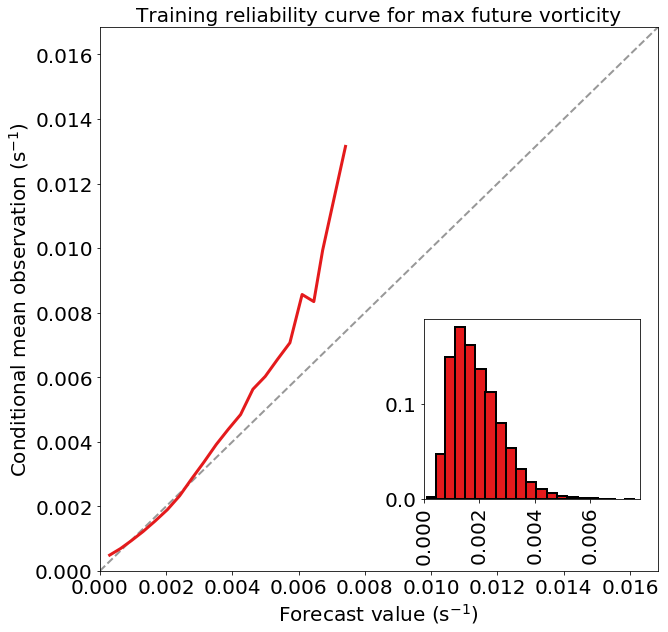



--------------------------------------------------


Validation MAE (mean absolute error) = 7.910e-04 s^-1
Validation MSE (mean squared error) = 1.193e-06 s^-2
Validation bias (mean signed error) = 7.027e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.279
Validation MSE skill score (improvement over climatology) = 0.477


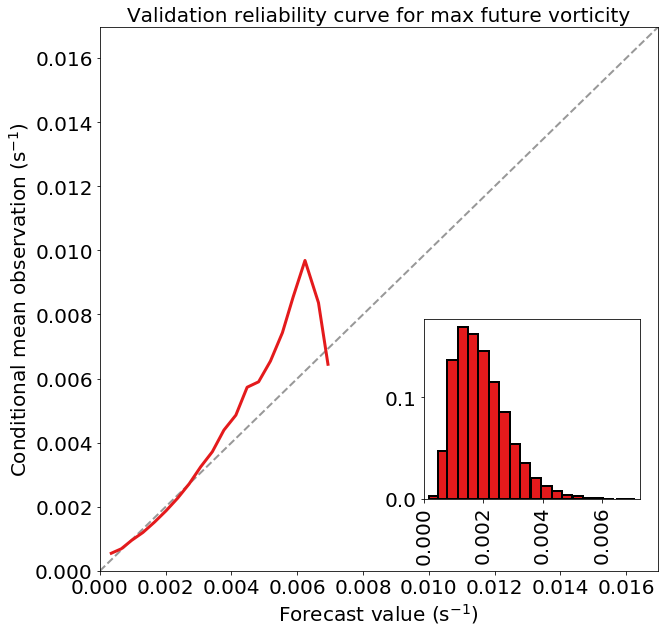

In [16]:
linear_ridge_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=1e5)

_ = utils.train_linear_regression(
    model_object=linear_ridge_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_ridge_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_ridge_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

# Linear Regression with $L_2$: Coefficients

The next cell plots coefficients for linear regression with only the $L_2$ penalty.
<br><br>
Note that coefficients are generally an order of magnitude smaller than in the original model ($10^{-5}$ to $10^{-4}$, instead of $10^{-4}$ to $10^{-3}$).
<br><br>
However, all coefficients are non-zero, because as discussed the $L_2$ penalty does not encourage coefficients to become **exactly** zero.

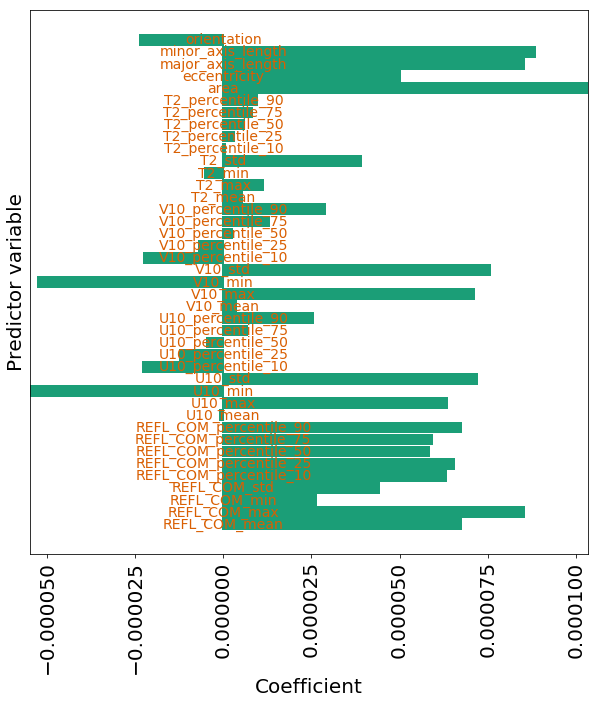

In [18]:
utils.plot_model_coefficients(
    model_object=linear_ridge_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with $L_1$: Example

The next cell trains a linear-regression model with only the $L_1$ penalty.  The regularization strength ($\lambda_1$) is $10^{-5}$.
<br><br>
Both training and validation performance get **a bit** worse than in the original model, which means that the $\lambda_1$ value is too high.
<br><br>
However, performance does not decrease as much as it did for $L_2$ regularization.

Training MAE (mean absolute error) = 7.893e-04 s^-1
Training MSE (mean squared error) = 1.168e-06 s^-2
Training bias (mean signed error) = 1.664e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.299
Training MSE skill score (improvement over climatology) = 0.497


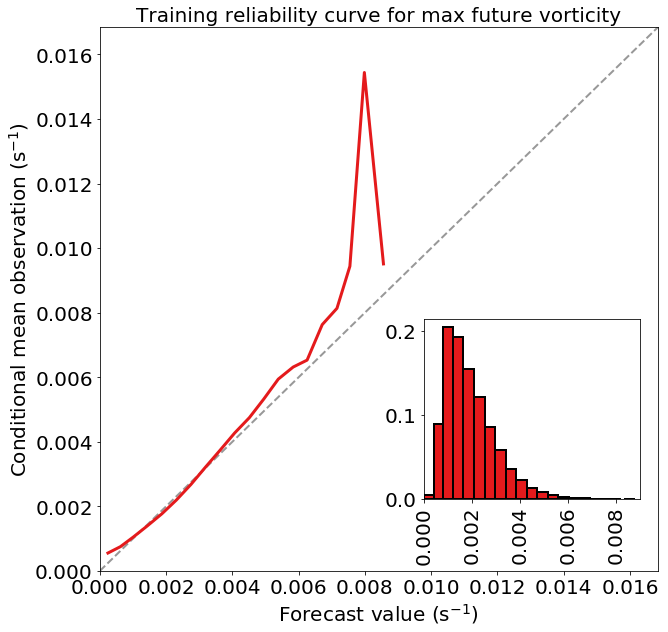



--------------------------------------------------


Validation MAE (mean absolute error) = 7.669e-04 s^-1
Validation MSE (mean squared error) = 1.103e-06 s^-2
Validation bias (mean signed error) = 1.086e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.301
Validation MSE skill score (improvement over climatology) = 0.516


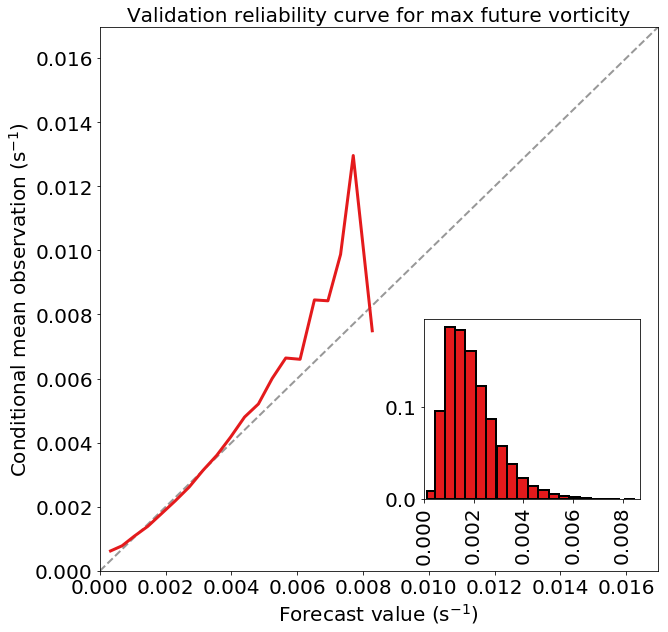

In [19]:
linear_lasso_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=0.)

_ = utils.train_linear_regression(
    model_object=linear_lasso_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_lasso_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_lasso_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

# Linear Regression with $L_1$: Coefficients

The next cell plots coefficients for linear regression with only the $L_1$ penalty.
<br><br>
Non-zero coefficients are generally on the same order of magnitude as the original model ($\sim10^{-4}$).
<br><br>
However, many coefficients (25 of 41) have been "zeroed out".  This means that the model uses only 16 of the 41 predictors.  (Note: This result may vary slightly if you run the model again, since I'm not sure if all the randomness has been controlled.)

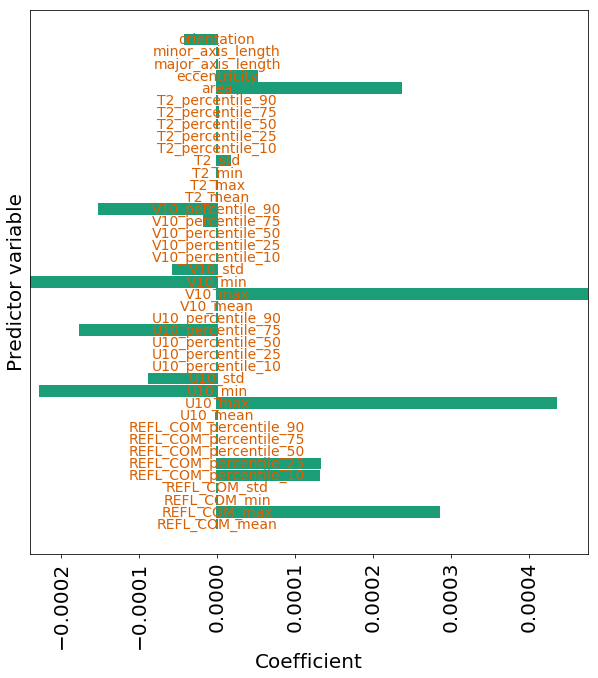

In [20]:
utils.plot_model_coefficients(
    model_object=linear_lasso_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with $L_1$ and $L_2$: Example

 - The next cell trains a linear-regression model with both penalties.
 - Whereas $L_1$ only is called the "lasso penalty" and $L_2$ only is called the "ridge penalty," this is called the "elastic net".
<br><br>
 - In the literature you may see people talk about "lasso regression," "ridge regression," and "elastic-net regression".
 - **These are not real things**.  The lasso, ridge, and elastic-net penalties can be applied to any kind of model.
 - When people say "lasso regression," "ridge regression," and "elastic-net regression," they generally mean linear regression with the given penalty.
 - However, this is not always true, so be careful.
<br><br>
In this elastic net makes training and validation performance **much worse**, because the values are too high ($\lambda_1 = 10^{-5}$ and $\lambda_2 = 5$).

Training MAE (mean absolute error) = 8.554e-04 s^-1
Training MSE (mean squared error) = 1.396e-06 s^-2
Training bias (mean signed error) = 3.467e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.241
Training MSE skill score (improvement over climatology) = 0.399


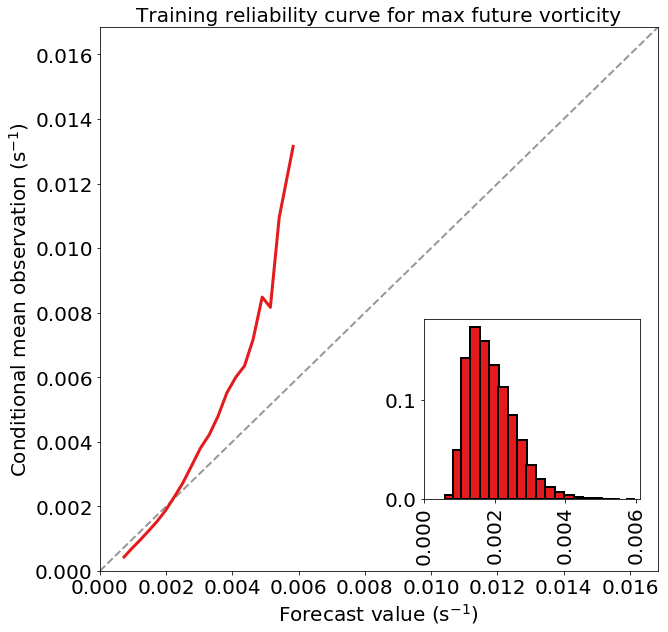



--------------------------------------------------


Validation MAE (mean absolute error) = 8.370e-04 s^-1
Validation MSE (mean squared error) = 1.344e-06 s^-2
Validation bias (mean signed error) = 4.480e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.237
Validation MSE skill score (improvement over climatology) = 0.410


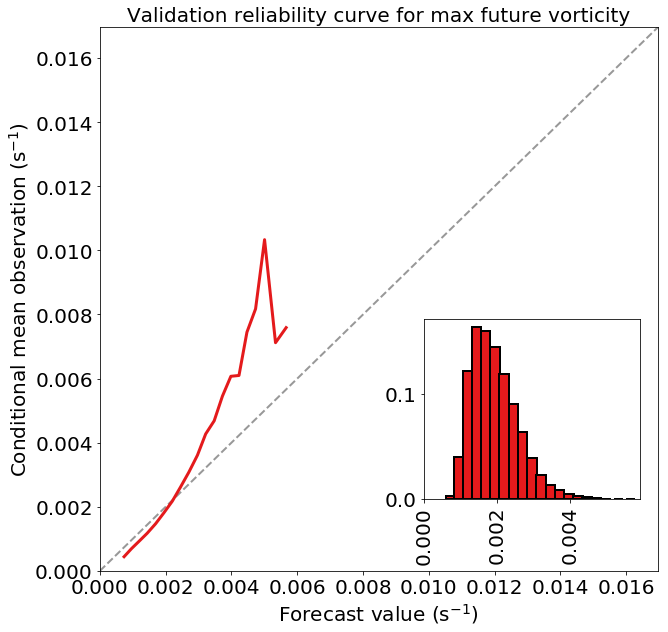

In [21]:
linear_en_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=5.)

_ = utils.train_linear_regression(
    model_object=linear_en_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_en_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_en_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

# Linear Regression with $L_1$ and $L_2$: Coefficients

The next cell plots coefficients for linear regression with both penalties.
<br><br>
In general the coefficients are an order of magnitude smaller than the original model.  Also, there are not many zero coefficients.
<br><br>
This means that, with the chosen $\lambda_1$ and $\lambda_2$, $L_2$ regularization "drowned out" $L_1$ regularization.

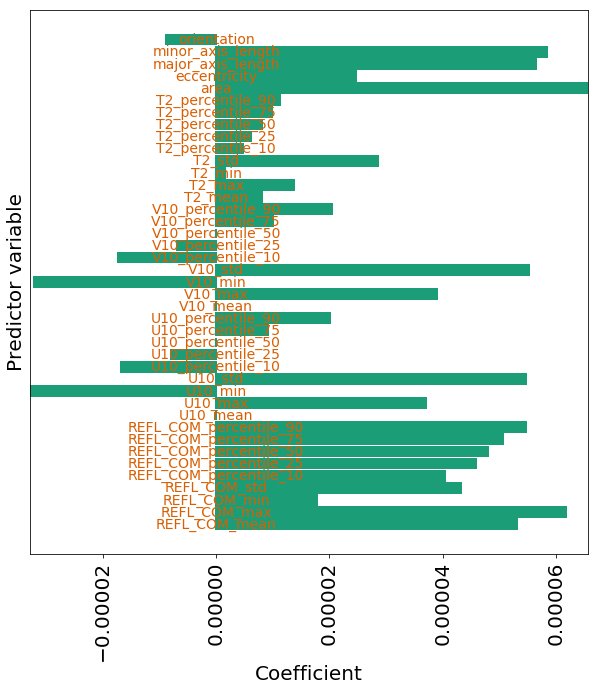

In [22]:
utils.plot_model_coefficients(
    model_object=linear_en_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Hyperparameter Experiment with $L_1$ and $L_2$ Regularization

The next few cells will show you how to conduct a "hyperparameter experiment".  The steps in a hyperparameter experiment are as follows.

 1. Choose the values to be attempted.  This is usually based on some *a priori* knowledge about how the model works.  The more expertise you have, the narrower you can make the range of attempted values.  In this case we attempt $\lambda_1 \in \lbrace 10^{-8}, 10^{-7.5}, 10^{-7}, 10^{-6.5}, 10^{-6}, 10^{-5.5}, 10^{-5}, 10^{-4.5}, 10^{-4} \rbrace$ and $\lambda_2 \in \lbrace 10^{-4}, 10^{-3.5}, 10^{-3}, 10^{-2.5}, 10^{-2}, 10^{-1.5}, 10^{-1}, 10^{-0.5}, 10^{0}, 10^{0.5}, 10^{1} \rbrace$.
 2. Train a model with each combination of hyperparameters.  In this case there are 9 values for $\lambda_1$ and 11 values for $\lambda_2$, so 99 combinations.  This is called a "grid search".  (Note: There are search methods other than grid search.  These become useful especially when the number of combinations is too large ("combinatiorial explosion"), which usually happens if you are experimenting with anymore than a few hyperparameters.  In this case you can do random search or beam search, use a genetic algorithm to evolve the hyperparameters, etc.  But we will stick with grid search in this module.)
 3. Evaluate each model on the validation data.
 4. Find the model that performs best on the validation data.  Again, there are many ways to define "best".  In this case we will select the model with the highest MAE skill score.

# Hyperparameter Experiment: Training

The next cell performs steps 1 and 2 of the hyperparameter experiment (defining the values to be attempted and training the models).

In [24]:
lambda1_values = numpy.logspace(-8, -4, num=9)
lambda2_values = numpy.logspace(-4, 1, num=11)

num_lambda1 = len(lambda1_values)
num_lambda2 = len(lambda2_values)

validation_mae_matrix_s01 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_matrix_s02 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mae_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)

mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

for i in range(num_lambda1):
    for j in range(num_lambda2):
        this_message_string = (
            'Training model with lasso coeff = 10^{0:.1f}, ridge coeff = '
            '10^{1:.1f}...'
        ).format(
            numpy.log10(lambda1_values[i]), numpy.log10(lambda2_values[j])
        )

        print(this_message_string)

        this_model_object = utils.setup_linear_regression(
            lambda1=lambda1_values[i], lambda2=lambda2_values[j]
        )

        _ = utils.train_linear_regression(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table)

        these_validation_predictions = this_model_object.predict(
            validation_predictor_table.as_matrix()
        )

        this_evaluation_dict = utils.evaluate_regression(
            target_values=validation_target_table[utils.TARGET_NAME].values,
            predicted_target_values=these_validation_predictions,
            mean_training_target_value=mean_training_target_value,
            verbose=False, create_plots=False)

        validation_mae_matrix_s01[i, j] = this_evaluation_dict[
            utils.MAE_KEY]
        validation_mse_matrix_s02[i, j] = this_evaluation_dict[
            utils.MSE_KEY]
        validation_mae_skill_matrix[i, j] = this_evaluation_dict[
            utils.MAE_SKILL_SCORE_KEY]
        validation_mse_skill_matrix[i, j] = this_evaluation_dict[
            utils.MSE_SKILL_SCORE_KEY]

Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^1.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-7.5, ridge co

# Hyperparameter Experiment: Validation

The next cell performs step 3 of the hyperparameter experiment (evaluates each model on the validation data).

Text(0.5, 1.0, 'MSE skill score on validation data')

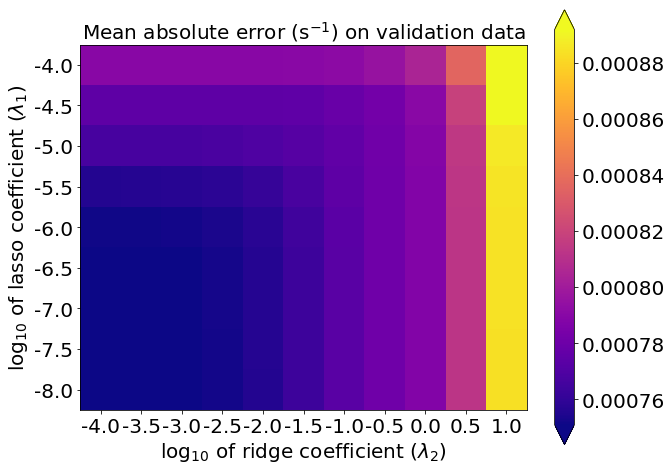

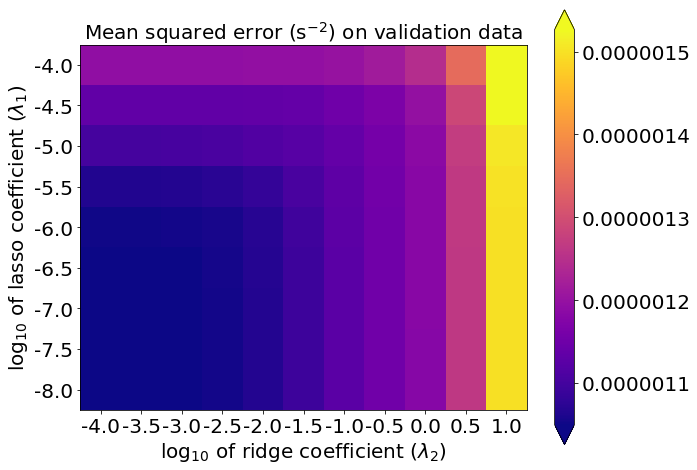

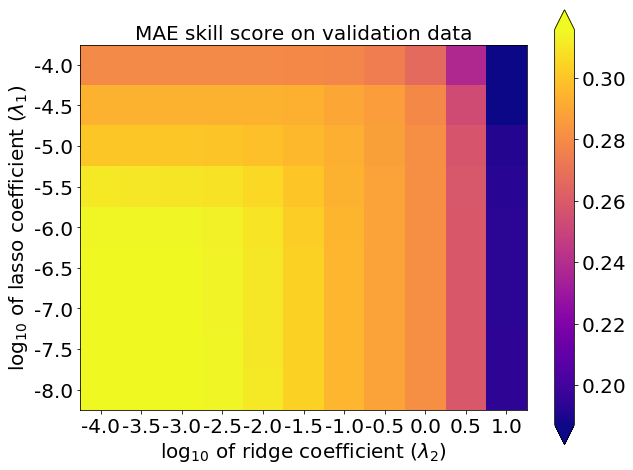

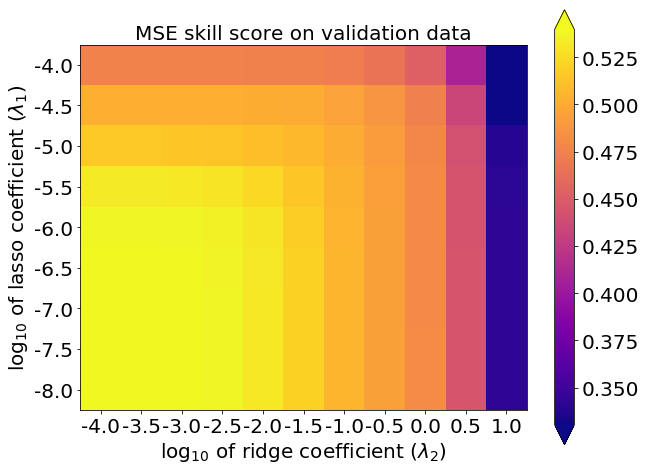

In [25]:
utils.plot_scores_2d(
    score_matrix=validation_mae_matrix_s01,
    min_colour_value=numpy.percentile(validation_mae_matrix_s01, 1.),
    max_colour_value=numpy.percentile(validation_mae_matrix_s01, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean absolute error (s$^{-1}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_matrix_s02,
    min_colour_value=numpy.percentile(validation_mse_matrix_s02, 1.),
    max_colour_value=numpy.percentile(validation_mse_matrix_s02, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean squared error (s$^{-2}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mae_skill_matrix,
    min_colour_value=numpy.percentile(validation_mae_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mae_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MAE skill score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_skill_matrix,
    min_colour_value=numpy.percentile(validation_mse_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mse_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MSE skill score on validation data')

# Hyperparameter Experiment: Selection

The next cell performs step 4 of the hyperparameter experiment (select model).

Best MAE skill score on validation data = 0.316 ... corresponding lasso coeff = 10^-6.5, ridge coeff = 10^-4.0
Testing MAE (mean absolute error) = 8.257e-04 s^-1
Testing MSE (mean squared error) = 1.413e-06 s^-2
Testing bias (mean signed error) = -8.985e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.338
Testing MSE skill score (improvement over climatology) = 0.555


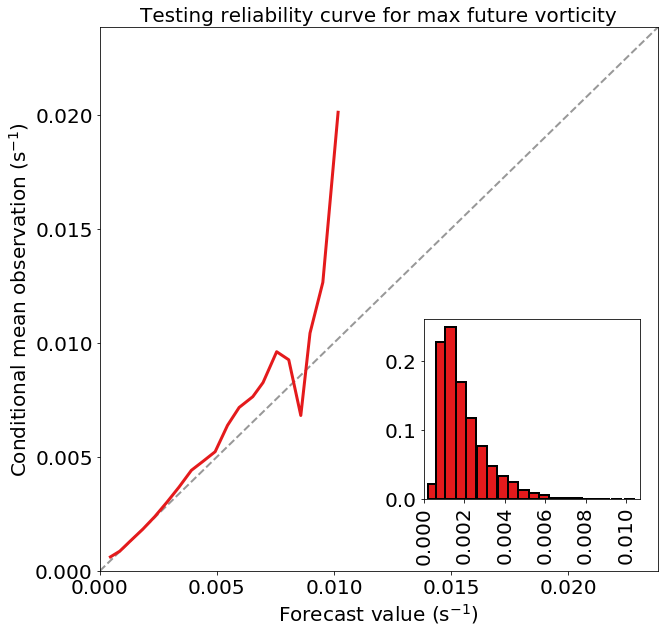

In [26]:
best_linear_index = numpy.argmax(numpy.ravel(validation_mae_skill_matrix))

best_lambda1_index, best_lambda2_index = numpy.unravel_index(
    best_linear_index, (len(lambda1_values), len(lambda2_values))
)

best_lambda1 = lambda1_values[best_lambda1_index]
best_lambda2 = lambda2_values[best_lambda2_index]
best_validation_maess = numpy.max(validation_mae_skill_matrix)

message_string = (
    'Best MAE skill score on validation data = {0:.3f} ... corresponding '
    'lasso coeff = 10^{1:.1f}, ridge coeff = 10^{2:.1f}'
).format(
    best_validation_maess, numpy.log10(best_lambda1),
    numpy.log10(best_lambda2)
)

print(message_string)

final_model_object = utils.setup_linear_regression(
    lambda1=best_lambda1, lambda2=best_lambda2)

_ = utils.train_linear_regression(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

testing_predictions = final_model_object.predict(
    testing_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

this_evaluation_dict = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=testing_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='testing')

# Binary Classification

 - The rest of this module focuses on binary classification, rather than regression.
 - "Regression" is the prediction of a real number (*e.g.*, above, where we predicted max future vorticity).
 - "Classification" is the prediction of a category (*e.g.*, low, medium, or high max future vorticity).
<br><br>
 - In binary classification there are two categories.
 - Thus, prediction takes the form of answering a yes-or-no question.
 - We will use the same target variable (max future vorticity), except we will binarize it.
 - The problem will be predicting whether or not max future vorticity exceeds a threshold.

# Binarization

 - The next cell "binarizes" the target variable (turns each value into a 0 or 1, yes or no).
 - The threshold is the 90$^{\textrm{th}}$ percentile of max future vorticity over all training examples.
 - The same threshold is used to binarize training, validation, and testing data.

In [27]:
binarization_threshold = utils.get_binarization_threshold(
    csv_file_names=training_file_names, percentile_level=90.)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    'Real-numbered target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    '\nBinarized target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

# Logistic Regression

Logistic regression is basically linear regression for binary classification.
<br><br>
Recall the equation for linear regression:
<br>
$\hat{y} = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$
<br><br>
Only the left-hand side is changed for logistic regression:
<br>
$\textrm{ln}(\frac{\hat{y}}{1 - \hat{y}}) = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$
<br><br>
This can be rewritten as:
<br>
$\hat{y} = \frac{\textrm{exp}(\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j)}{1 + \textrm{exp}(\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j)}$
<br><br>
This forces $\hat{y}$ to have limits of $\left[0, 1\right]$, so it can be interpreted as a probability.
<br>
The weights ($\beta_0$ and $\beta_j$) are trained to minimize cross-entropy, rather than mean squared error.
<br>
$\epsilon = -\frac{1}{N} \sum\limits_{i = 1}^{N} \left[ y_i\textrm{ log}_2(\hat{y}_i) + (1 - y_i)\textrm{ log}_2(1 - \hat{y}_i) \right]$
<br>
 - $\hat{y}_i$ = forecast probability for $i^{\textrm{th}}$ example.  This is probability that the event occurs (so class = 1 or "yes").  In our case, this is probability that max future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$.
 - $y_i$ = true label for $i^{\textrm{th}}$ example (0 or 1)
 - $N$ = number of training examples
 - $\epsilon$ = cross-entropy
<br><br>
 - Cross-entropy varies from $\left[0, \infty\right)$ and is negatively oriented (lower is better).
 - Cross-entropy comes from information theory and is proportional to the number of bits needed to describe the difference between the two distributions (predictions and labels).
 - When the distributions are equivalent ($\hat{y}_i = 1.0$ for all positive examples and $\hat{y}_i = 0.0$ for all negative examples), the number of bits is zero, so cross-entropy is zero.
<br><br>
As for linear regression, the derivatives of model coefficients with respect to cross-entropy are as follows.
<br>
$\frac{\partial \epsilon}{\partial \beta_0} = \frac{2}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
<br>
$\frac{\partial \epsilon}{\partial \beta_j} = \frac{2}{N} \sum\limits_{i = 1}^{N} x_{ij} (\hat{y}_i - y_i)$
<br><br>
As for linear regression, the weights ($\beta_0$ and $\beta_j$) are adjusted during training via gradient descent.

$\beta_0 \leftarrow \beta_0 - \alpha \frac{\partial \epsilon}{\partial \beta_0}$
<br>
$\beta_j \leftarrow \beta_j - \alpha \frac{\partial \epsilon}{\partial \beta_j}$

# Logistic Regression: Example

**The next cell does the following:**

 - Trains a logistic-regression model (with default hyperparameters) to predict the label for each storm (whether or not max future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$).
 - Evaluates the model on both training and validation data.

**For both training and validation data, this cell plots the following graphics:**

 - ROC (receiver operating characteristic) curve (Metz 1978)
 - Performance diagram (Roebber 2009)
 - Attributes diagram (Hsu and Murphy 1986)

These graphics are described below the cell.

Training Max Peirce score (POD - POFD) = 0.610
Training AUC (area under ROC curve) = 0.882
Training Max CSI (critical success index) = 0.348
Training Brier score = 0.066
Training Brier skill score (improvement over climatology) = 0.270


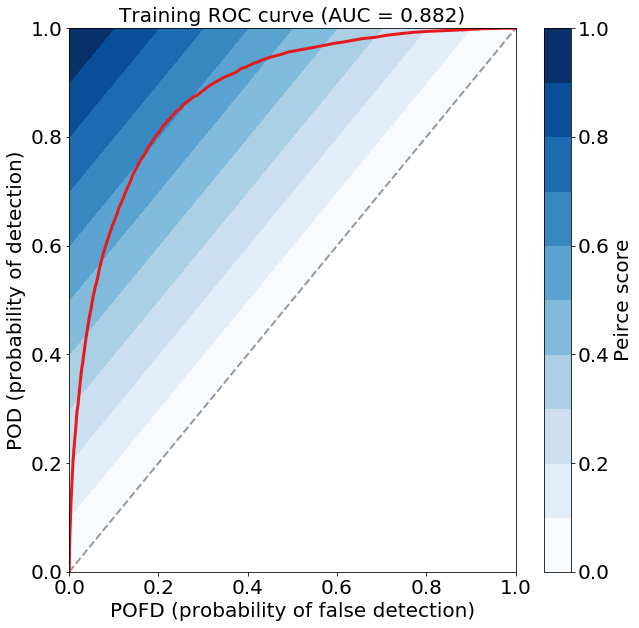

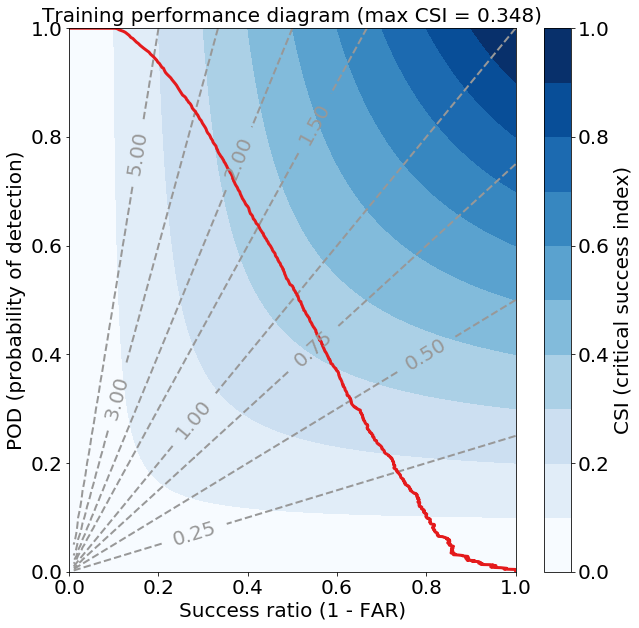

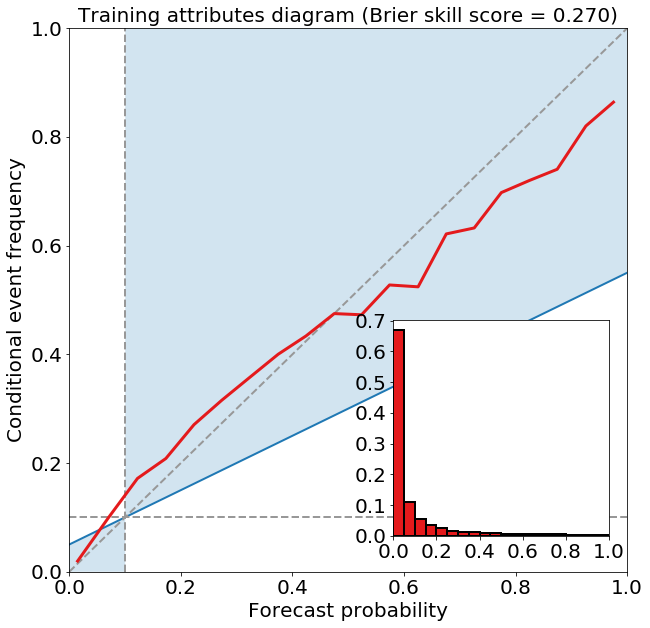

Validation Max Peirce score (POD - POFD) = 0.637
Validation AUC (area under ROC curve) = 0.896
Validation Max CSI (critical success index) = 0.375
Validation Brier score = 0.063
Validation Brier skill score (improvement over climatology) = 0.300


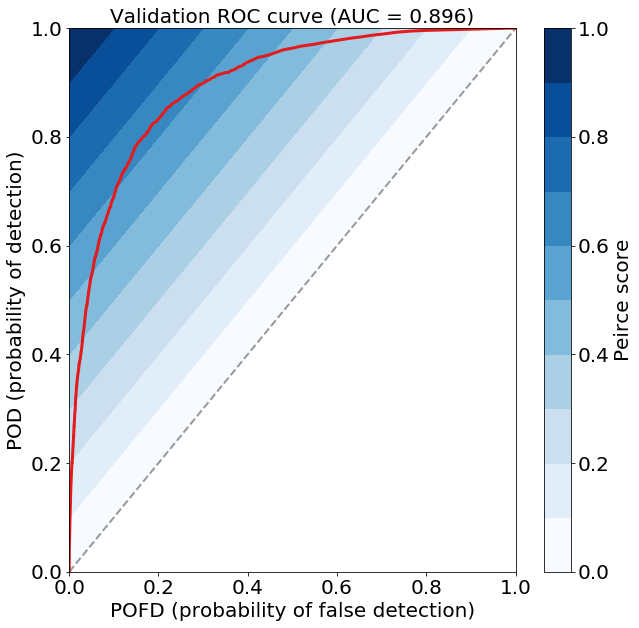

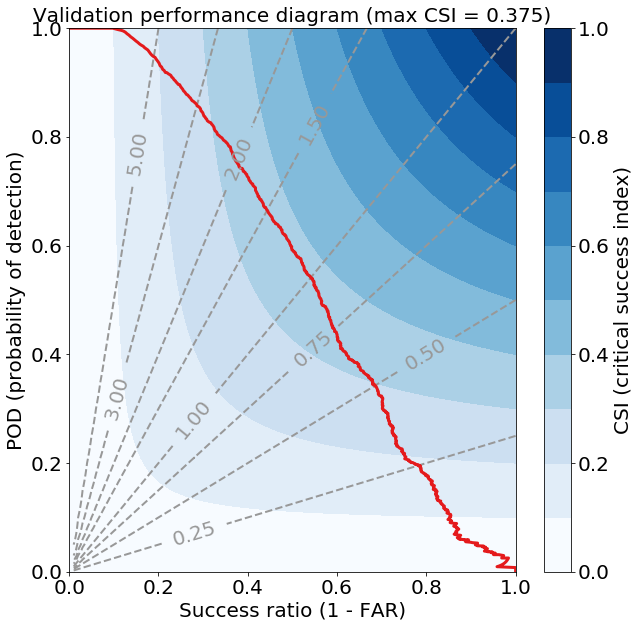

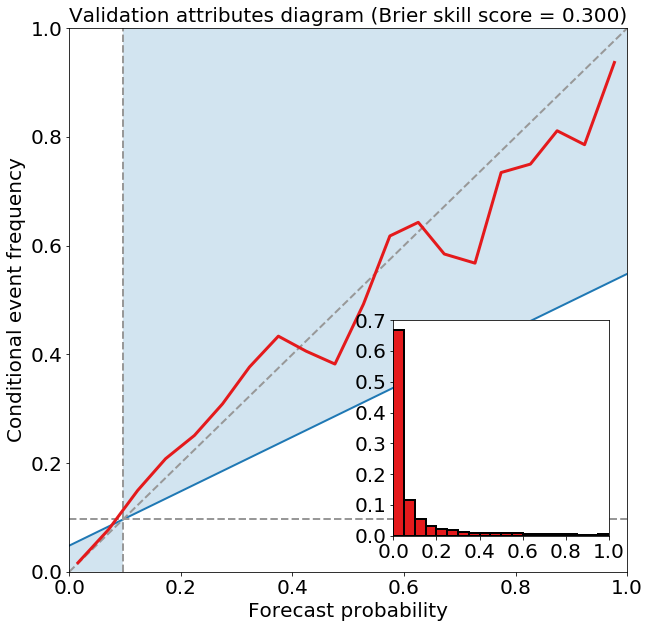

{'max_peirce_score': 0.6368314214043145,
 'area_under_roc_curve': 0.8959112864602312,
 'max_csi': 0.37543391188251,
 'brier_score': 0.06319228121775292,
 'brier_skill_score': 0.30000519191474795}

In [28]:
plain_log_model_object = utils.setup_logistic_regression(
    lambda1=0., lambda2=0.)

_ = utils.train_logistic_regression(
    model_object=plain_log_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = plain_log_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = plain_log_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Contingency Tables

Most evaluation methods for binary classification are based on the contingency table (or "confusion matrix"), shown below.

<img src="contingency_table.png" alt="Contingency table" width="500" />

 - $a$ = number of true positives (forecast = label = "yes")
 - $b$ = number of false positives (forecast = "yes" but label = "no")
 - $c$ = number of false negatives (forecast = "no" but label = "yes")
 - $d$ = number of true negatives (forecast = label = "no")
<br><br>
 - **Problem**: most classification models (including logistic regression) output probabilities, rather than yeses and nos.
 - **Solution**: determinize the probabilities.
 - "Determinize" is just a fancy way of saying "turn the probabilities into yeses and nos".
 - This is done with the following equation, where $p$ = probability; $p^*$ = threshold; and $\hat{y}$ is the resulting deterministic forecast.

$\hat{y} = \begin{cases}1,\quad\textrm{if }p \ge p^* \\0,\quad\textrm{otherwise}\end{cases}$

 - The best threshold is usually **not** 0.5.
 - Keep in mind that $p^*$ is a hyperparameter, so it should be optimized on the validation data.

The following scores can be computed from the contingency table.

<img src="ct_scores.png" alt="Scores from contingency table" width="500" />

# ROC Curve

 - The ROC curve plots POD (probability of detection) vs. POFD (probability of false detection) with varying threshold $p^*$.
 - Each point in the curve corresponds to one $p^*$ value.
 - For $p^*$ = 0, POD = POFD = 1.
 - For $p^*$ = 1, POD = POFD = 0.

Two numbers can be used to summarize the goodness of the ROC curve:

 - Maximum Peirce score (POD - POFD) over all thresholds
 - Area under the curve (AUC)
 - Generally, an AUC $\ge$ 0.9 is considered "excellent".
 - AUC = 0.5 (dashed grey line) for a random model.

# Performance Diagram

 - The performance diagram plots POD (probability of detection) vs. success ratio (1 - FAR).
 - Again, each point corresponds to one $p^*$ value.
 - For $p^*$ = 0, POD = 1 and success ratio is minimized.
 - For $p^*$ = 1, POD = 0 and success ratio is maximized.

CSI (critical success index) and frequency bias are contoured in the background.  They can be expressed in POD&ndash;success-ratio space as follows.
<br><br>
$\textrm{bias} = \frac{\textrm{POD}}{\textrm{SR}}$
<br>
$\textrm{CSI}^{-1} = \textrm{POD}^{-1} + \textrm{SR}^{-1} - 1$
<br><br>

A few numbers can be used to summarize the goodness of the performance diagram:

 - Maximum CSI
 - Frequency bias at maximum CSI (should occur with a frequency bias near 1.0)
 - Area under curve
<br><br>
 - However, unlike the ROC curve, these numbers are very sensitive to the class distribution.
 - Thus, thresholds for "good" and "bad" depend on the class distribution.
 - For some rare events a max CSI of 0.10 may be excellent; for common events a max CSI of 0.8 may be poor.

# Attributes Diagram

 - The attributes diagram is a reliability curve for binary classification, plus a few reference lines in the background.
 - Plots forecast probability vs. conditional mean frequency.
 - This answers the question: "given forecast probability $p$, how likely is the event?"
<br><br>
 - For perfect reliability, conditional event frequency = forecast probability always.
 - This is represented by the diagonal grey line ($x = y$), called the "perfect-reliability line".
 - The vertical grey line is the "climatology line," representing the event frequency in the training data, which is just called "climatology".  Climatology in our case is 10%.  If the model always forecast climatology, the reliability curve would collapse to a single point on this line.
 - The horizontal grey line is the "no-resolution line," also based on training-set climatology.  If the model were completely random, the reliability curve would approx follow this line.
<br><br>
 - The blue shading is the "positive-skill area," where Brier skill score $>$ 0.
 - Brier skill score (BSS) is the Brier score (BS) relative to climatology.
<br><br>
$\textrm{BS} = \frac{1}{N} \sum\limits_{i = 1}^{N} (p_i - y_i)^2$
<br>
$\textrm{BSS} = \frac{\textrm{BS}_{\textrm{climo}} - \textrm{BS}}{\textrm{BS}_{\textrm{climo}}}$

# Logistic Regression: Coefficients

 - The next cell plots coefficients for the logistic-regression model.
 - Positive (negative) coefficients mean that probability increases (decreases) with the predictor variable.
 - Again, predictors have been normalized to the same scale ($z$-scores), so generally predictors with larger coefficients are more important.

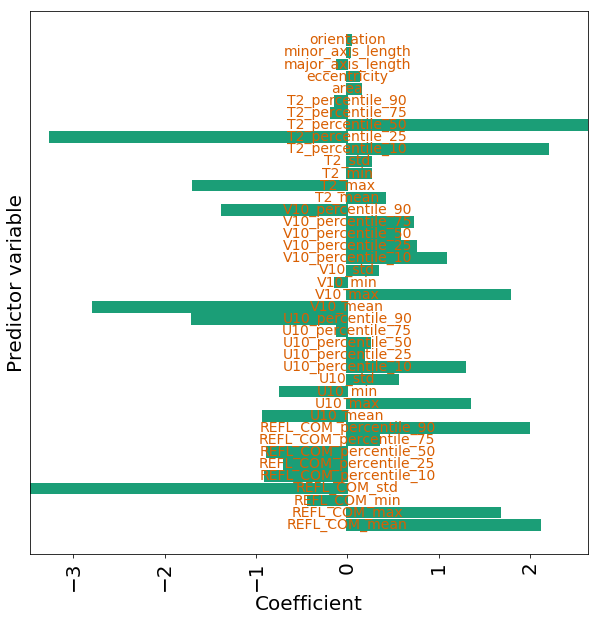

In [29]:
utils.plot_model_coefficients(
    model_object=plain_log_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Logistic Regression with $L_1$ and $L_2$

 - The next cell trains a logistic-regression model with both $L_1$ and $L_2$ regularization.
 - As for linear regression, you could do a hyperparameter experiment to find the best $\lambda_1$ and $\lambda_2$ for logistic regression.
 - Now you can see why just saying "lasso regression" or "ridge regression" or "elastic-net regression" is not descriptive enough.  This type of regularization can be applied to different base models.

Validation Max Peirce score (POD - POFD) = 0.663
Validation AUC (area under ROC curve) = 0.907
Validation Max CSI (critical success index) = 0.394
Validation Brier score = 0.061
Validation Brier skill score (improvement over climatology) = 0.321


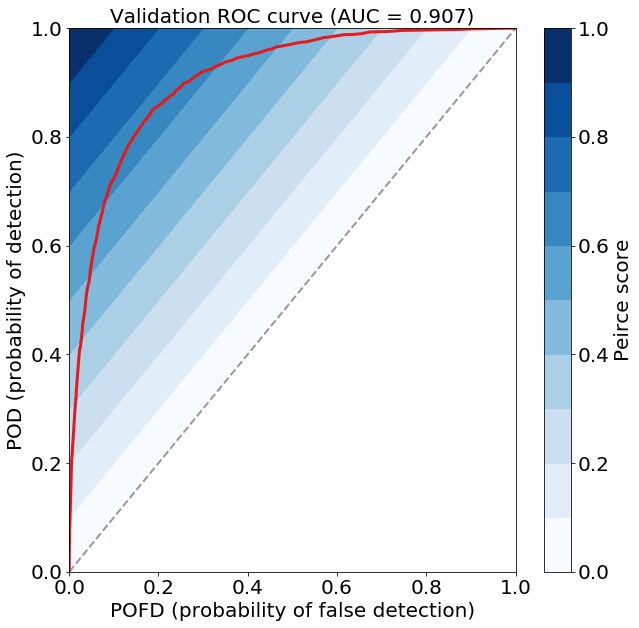

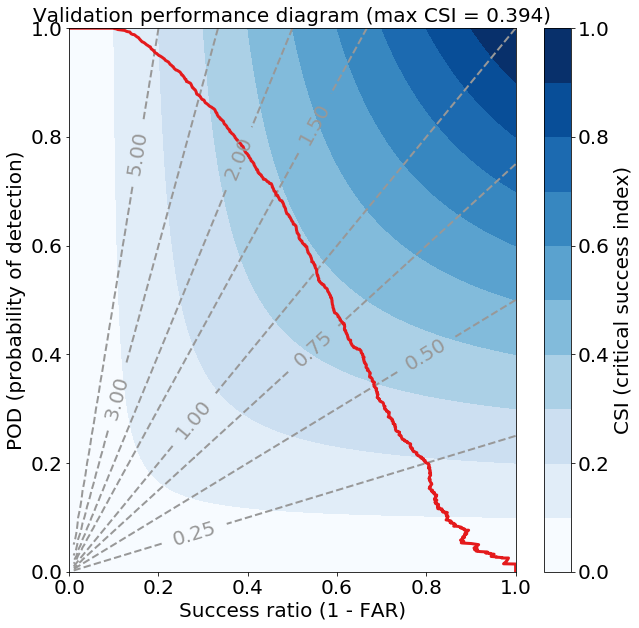

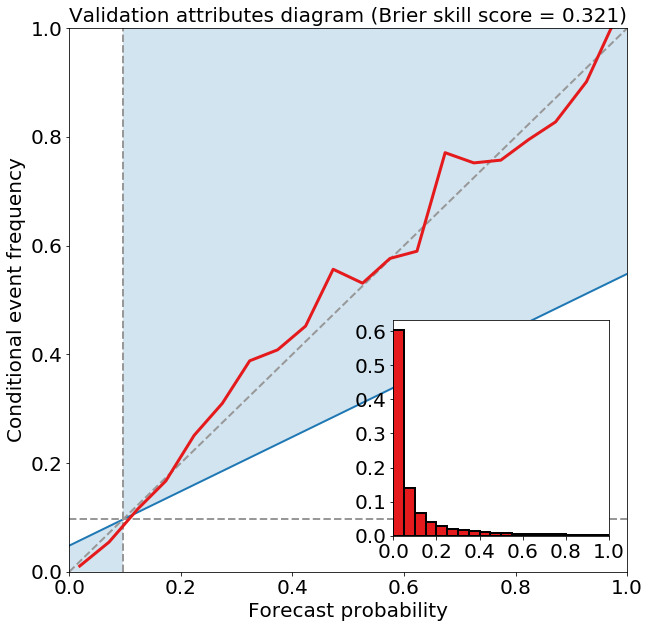

{'max_peirce_score': 0.663143641205373,
 'area_under_roc_curve': 0.9074246696304128,
 'max_csi': 0.39361702127659576,
 'brier_score': 0.06132725699724141,
 'brier_skill_score': 0.3206644757094362}

In [30]:
logistic_en_model_object = utils.setup_logistic_regression(
    lambda1=1e-3, lambda2=1e-3)

_ = utils.train_logistic_regression(
    model_object=logistic_en_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

validation_probabilities = logistic_en_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Logistic Regression with $L_1$ and $L_2$: Coefficients

The next cell plots coefficients for the logistic-regression model with both penalties.
<br><br>
Many coefficients are zero, and the non-zero ones are about an order of magnitude smaller than for the original model.

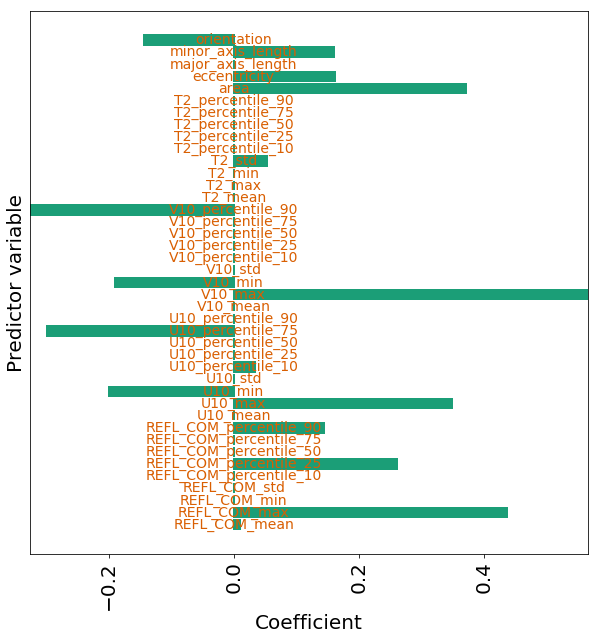

In [31]:
utils.plot_model_coefficients(
    model_object=logistic_en_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Decision Trees

 - A decision tree is a flow chart with **branch nodes** (ellipses) and **leaf nodes** (rectangles).

<img src="tree_schematic.jpg" alt="Decision-tree schematic" width="500" />
 
 - The branch nodes are bifurcating, and the leaf nodes are terminal.
 - In other words, each branch node has 2 children and each leaf node has 0 children.
 - Predictions are made at the leaf nodes, and questions are asked at the branch nodes.
 - Since the branch nodes are bifurcating, questions asked at the branch nodes must be yes-or-no.
<br><br>
 - Decision trees have been used in meteorology since the 1960s (Chisholm 1968).
 - They were built subjectively by human experts until the 1980s, when an objective algorithm (Quinlan 1986) was developed to "train" them (determine the best question at each branch node).
<br><br>
 - The prediction at leaf node $L$ is the average of all training examples that reached $L$.
 - For regression this is a real value (average max future vorticity of examples that reached $L$).
 - For classification this is a probability (fraction of examples that reached $L$ with max future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$).
<br><br>
 - The question chosen at each branch node is that which maximizes information gain.
 - This is done by minimizing the "remainder," which is based on entropy of the child nodes.
 - The entropy of one node is defined below.
<br><br>
$E = -\frac{1}{n} \left[ f\textrm{ log}_2(f) + f\textrm{ log}_2(f) \right]$
<br><br>
 - $n$ = number of examples at the node
 - $f$ = fraction of these examples that are in the positive class
<br><br>
The "remainder" is defined as follows.
<br><br>
$R = \frac{n_{\textrm{left}} E_{\textrm{left}} + n_{\textrm{right}} E_{\textrm{right}}}{n_{\textrm{left}} + n_{\textrm{right}}}$
<br><br>
 - $n_{\textrm{left}}$ = number of examples sent to left child (for which the answer to the question is "no")
 - $n_{\textrm{left}}$ = number of examples sent to right child (for which answer is "yes")
 - $E_{\textrm{left}}$ = entropy of left child
 - $E_{\textrm{right}}$ = entropy of right child

# Decision Tree: Example

The next cell trains a decision tree, with default hyperparameters, to forecast the probability that a storm will develop future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$.

Training Max Peirce score (POD - POFD) = 0.781
Training AUC (area under ROC curve) = 0.955
Training Max CSI (critical success index) = 0.471
Training Brier score = 0.049
Training Brier skill score (improvement over climatology) = 0.459


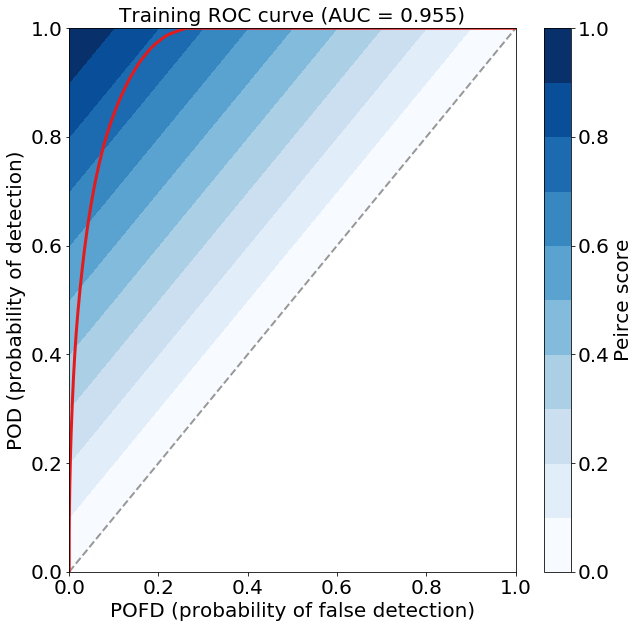

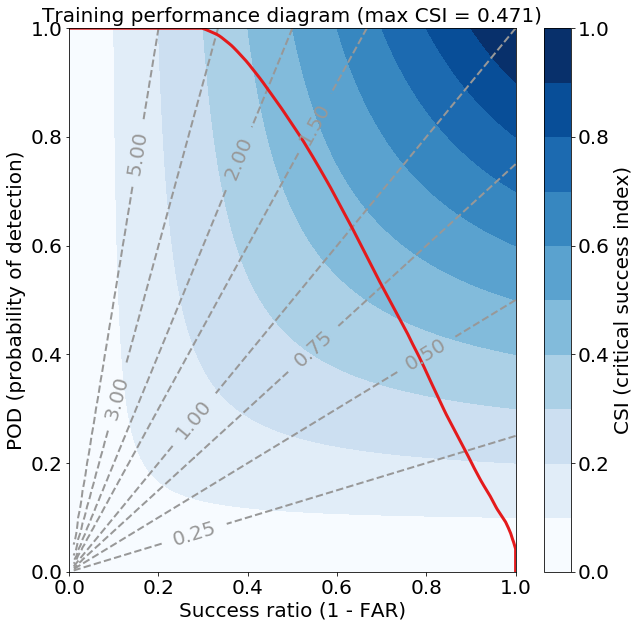

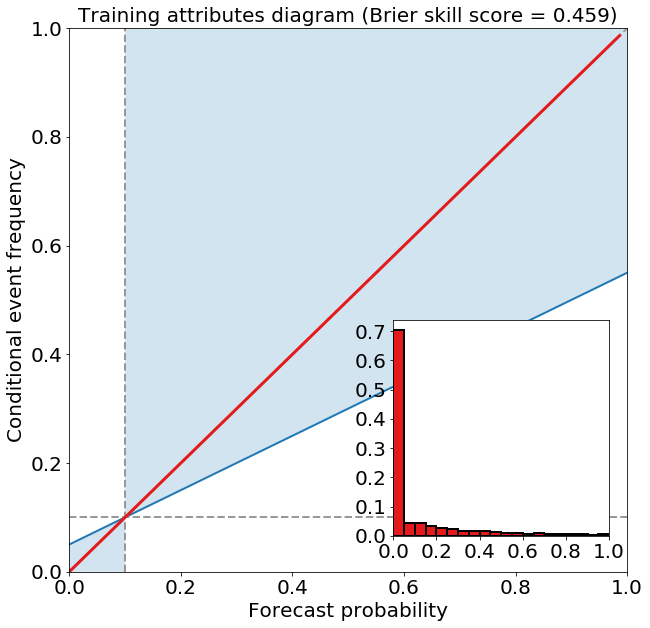

Validation Max Peirce score (POD - POFD) = 0.598
Validation AUC (area under ROC curve) = 0.854
Validation Max CSI (critical success index) = 0.342
Validation Brier score = 0.069
Validation Brier skill score (improvement over climatology) = 0.233


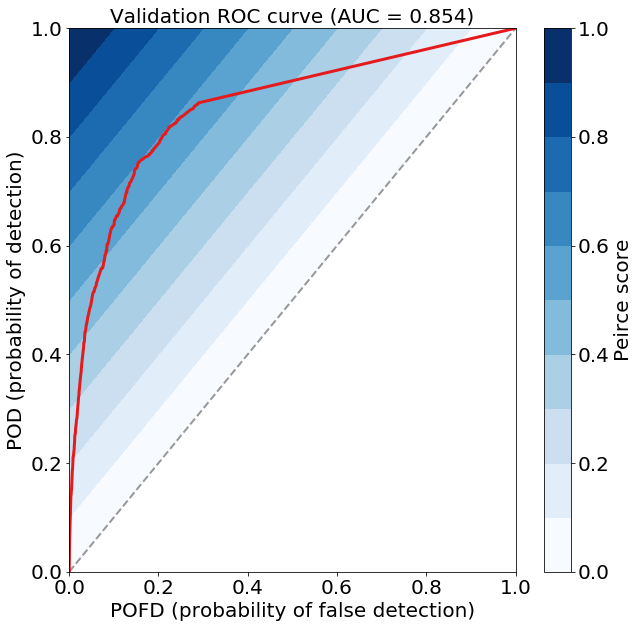

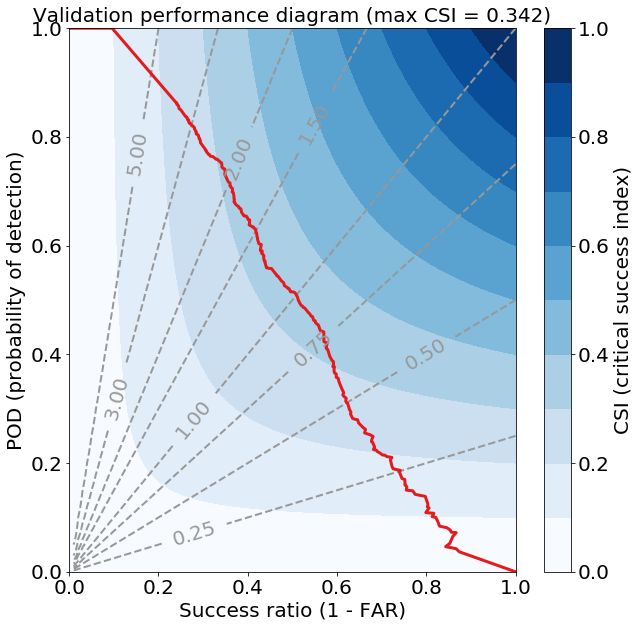

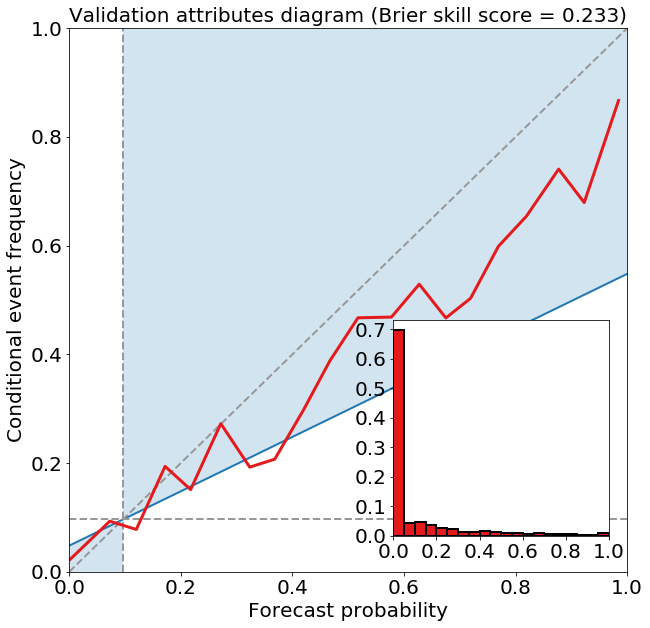

{'max_peirce_score': 0.5977671359299315,
 'area_under_roc_curve': 0.8539744298017814,
 'max_csi': 0.3418826739427013,
 'brier_score': 0.0692540584940177,
 'brier_skill_score': 0.23285755078856513}

In [32]:
default_tree_model_object = utils.setup_classification_tree(
    min_examples_at_split=30, min_examples_at_leaf=30)

_ = utils.train_classification_tree(
    model_object=default_tree_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = default_tree_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = default_tree_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Hyperparameter Experiment with Minimum Sample Size

 - Two hyperparameters (among others) control the depth of a decision tree: minimum examples per branch node ($N_b^{\textrm{min}}$) and per leaf node ($N_l^{\textrm{min}}$).
 - If these values are set to 1, the tree can become very deep, which increases its ability to overfit.
 - You can think of this another way: if there is one example at each leaf node, all predictions will be based on only one example and will probably not generalize well to new data.
<br><br>
 - Conversely, if $N_b^{\textrm{min}}$ and $N_l^{\textrm{min}}$ are set too high, the tree will not become deep enough, causing it to underfit.
 - For example, suppose that you have 1000 training examples and set $N_l^{\textrm{min}}$ to 1000.
 - This will allow only one branch node (the root node); both children of the root node will have $<$ 1000 examples.
 - Thus, predictions will be based on only one question.
<br><br>
Recall the four steps of any hyperparameter experiment:

 1. Choose the values to be attempted.  We will try $N_b^{\textrm{min}} \in \lbrace 2, 5, 10, 20, 30, 40, 50, 100, 200, 500 \rbrace$ and $N_l^{\textrm{min}} \in \lbrace 1, 5, 10, 20, 30, 40, 50, 100, 200, 500 \rbrace$.  However, we will not try combinations where $N_l^{\textrm{min}} \ge N_b^{\textrm{min}}$, because this makes no sense (the child of a node with $N$ examples cannot have $\ge N$ examples).
 2. Train a model with each combination.
 3. Evaluate each model on the validation data.
 4. Select the model that performs best on validation data.  Here we will define "best" as that with the highest Brier skill score.

# Hyperparameter Experiment: Training

The next cell performs steps 1 and 2 of the hyperparameter experiment (defining the values to be attempted and training the models).

In [33]:
min_per_split_values = numpy.array(
    [2, 5, 10, 20, 30, 40, 50, 100, 200, 500], dtype=int)
min_per_leaf_values = numpy.array(
    [1, 5, 10, 20, 30, 40, 50, 100, 200, 500], dtype=int)

num_min_per_split_values = len(min_per_split_values)
num_min_per_leaf_values = len(min_per_leaf_values)

validation_auc_matrix = numpy.full(
    (num_min_per_split_values, num_min_per_leaf_values), numpy.nan
)

validation_max_csi_matrix = validation_auc_matrix + 0.
validation_bs_matrix = validation_auc_matrix + 0.
validation_bss_matrix = validation_auc_matrix + 0.

training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

for i in range(num_min_per_split_values):
    for j in range(num_min_per_leaf_values):
        if min_per_leaf_values[j] >= min_per_split_values[i]:
            continue

        this_message_string = (
            'Training model with minima of {0:d} examples per split node, '
            '{1:d} per leaf node...'
        ).format(min_per_split_values[i], min_per_leaf_values[j])

        print(this_message_string)

        this_model_object = utils.setup_classification_tree(
            min_examples_at_split=min_per_split_values[i],
            min_examples_at_leaf=min_per_leaf_values[j]
        )

        _ = utils.train_classification_tree(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table)

        these_validation_predictions = this_model_object.predict_proba(
            validation_predictor_table.as_matrix()
        )[:, 1]

        this_evaluation_dict = utils.eval_binary_classifn(
            observed_labels=validation_target_table[
                utils.BINARIZED_TARGET_NAME].values,
            forecast_probabilities=these_validation_predictions,
            training_event_frequency=training_event_frequency,
            create_plots=False, verbose=False)

        validation_auc_matrix[i, j] = this_evaluation_dict[utils.AUC_KEY]
        validation_max_csi_matrix[i, j] = this_evaluation_dict[
            utils.MAX_CSI_KEY]
        validation_bs_matrix[i, j] = this_evaluation_dict[
            utils.BRIER_SCORE_KEY]
        validation_bss_matrix[i, j] = this_evaluation_dict[
            utils.BRIER_SKILL_SCORE_KEY]

Training model with minima of 2 examples per split node, 1 per leaf node...
Training model with minima of 5 examples per split node, 1 per leaf node...
Training model with minima of 10 examples per split node, 1 per leaf node...
Training model with minima of 10 examples per split node, 5 per leaf node...
Training model with minima of 20 examples per split node, 1 per leaf node...
Training model with minima of 20 examples per split node, 5 per leaf node...
Training model with minima of 20 examples per split node, 10 per leaf node...
Training model with minima of 30 examples per split node, 1 per leaf node...
Training model with minima of 30 examples per split node, 5 per leaf node...
Training model with minima of 30 examples per split node, 10 per leaf node...
Training model with minima of 30 examples per split node, 20 per leaf node...
Training model with minima of 40 examples per split node, 1 per leaf node...
Training model with minima of 40 examples per split node, 5 per leaf node..

# Hyperparameter Experiment: Validation

The next cell performs step 3 of the hyperparameter experiment (evaluates each model on the validation data).

Text(0.5, 1.0, 'Brier skill score on validation data')

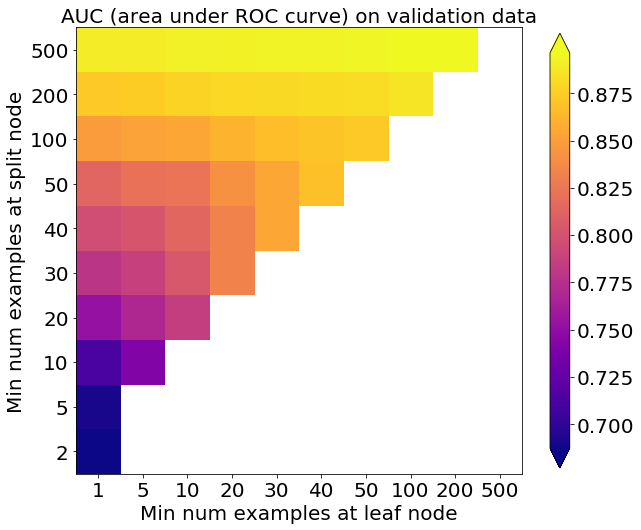

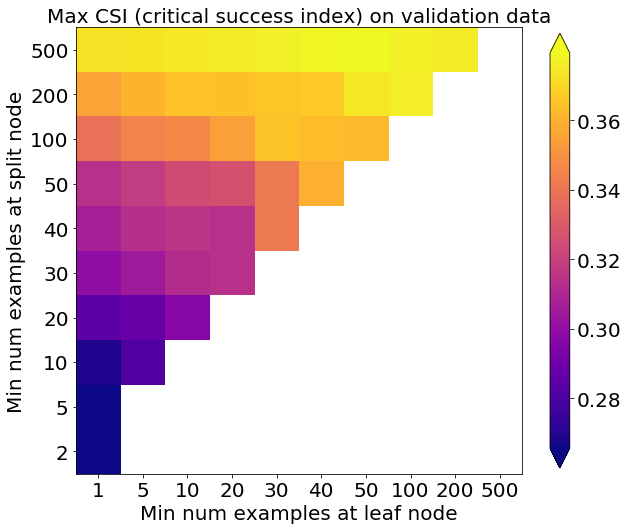

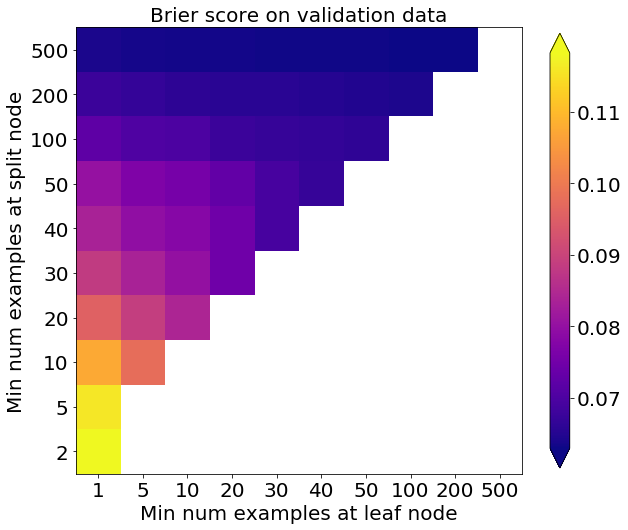

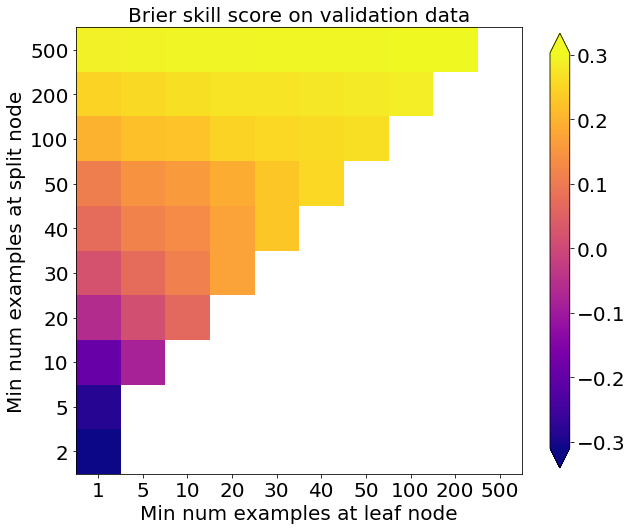

In [34]:
utils.plot_scores_2d(
    score_matrix=validation_auc_matrix,
    min_colour_value=numpy.nanpercentile(validation_auc_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_auc_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('AUC (area under ROC curve) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_max_csi_matrix,
    min_colour_value=numpy.nanpercentile(validation_max_csi_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_max_csi_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Max CSI (critical success index) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bs_matrix,
    min_colour_value=numpy.nanpercentile(validation_bs_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_bs_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Brier score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bss_matrix,
    min_colour_value=numpy.nanpercentile(validation_bss_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_bss_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Brier skill score on validation data')

# Hyperparameter Experiment: Selection

The next cell performs step 4 of the hyperparameter experiment (select model).

Best validation BSS = 0.304 ... corresponding min examples per split node = 500 ... min examples per leaf node = 200
Testing Max Peirce score (POD - POFD) = 0.657
Testing AUC (area under ROC curve) = 0.900
Testing Max CSI (critical success index) = 0.423
Testing Brier score = 0.053
Testing Brier skill score (improvement over climatology) = 0.412


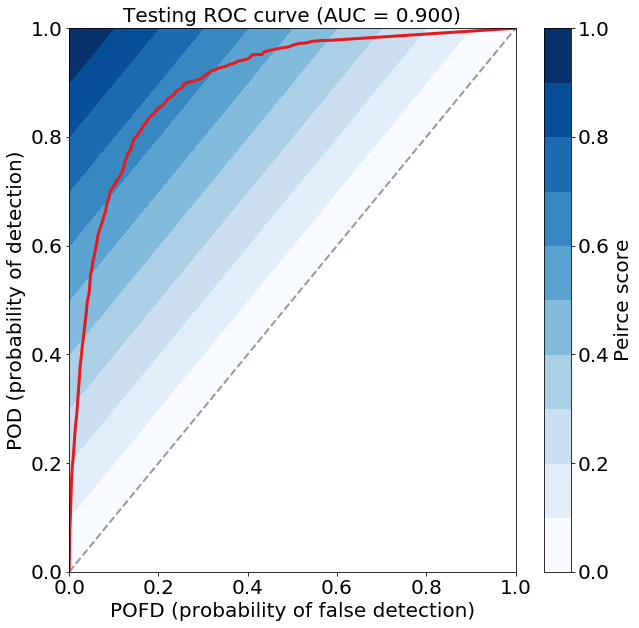

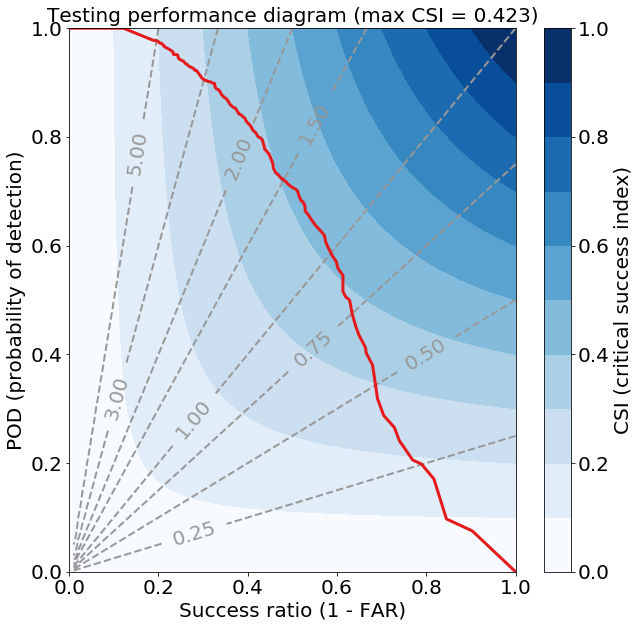

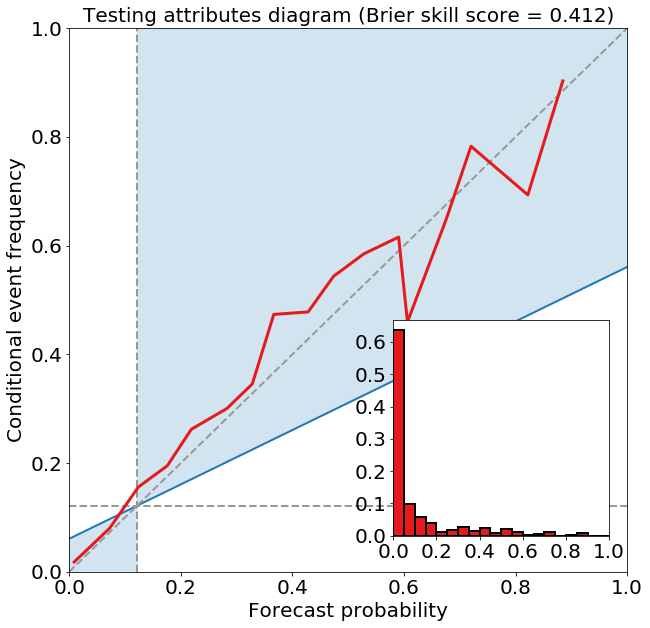

In [35]:
best_linear_index = numpy.nanargmax(numpy.ravel(validation_bss_matrix))

best_split_index, best_leaf_index = numpy.unravel_index(
    best_linear_index, validation_bss_matrix.shape)

best_min_examples_per_split = min_per_split_values[best_split_index]
best_min_examples_per_leaf = min_per_leaf_values[best_leaf_index]
best_validation_bss = numpy.nanmax(validation_bss_matrix)

message_string = (
    'Best validation BSS = {0:.3f} ... corresponding min examples per split'
    ' node = {1:d} ... min examples per leaf node = {2:d}'
).format(
    best_validation_bss, best_min_examples_per_split,
    best_min_examples_per_leaf
)

print(message_string)

final_model_object = utils.setup_classification_tree(
    min_examples_at_split=best_min_examples_per_split,
    min_examples_at_leaf=best_min_examples_per_leaf
)

_ = utils.train_classification_tree(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

testing_predictions = final_model_object.predict_proba(
    testing_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=testing_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=testing_predictions,
    training_event_frequency=training_event_frequency,
    create_plots=True, verbose=True, dataset_name='testing')

# Random Forests

 - A random forest is an ensemble of decision trees.
 - In the first example with decision trees, you may have noticed a lot of overfitting.
 - This is generally a problem with decision trees, because they rely on exact thresholds, which introduce "jumps" into the decision function.
 - For example, in the tree shown below, a difference of 0.0001 J kg$^{-1}$ in CAPE could lead to a difference of 55% in tornado probability.

<img src="tree_schematic.jpg" alt="Decision-tree schematic" width="500" />

 - One way to mitigate this overfitting is: train a bunch of decision trees.
 - **If the decision trees are diverse enough, they will hopefully have offsetting biases** (overfit in different ways).
 - **Random forests ensure diversity in two ways:**
     - Example-bagging
     - Predictor-bagging (or "feature-bagging")
<br><br>
 - **Example-bagging** is done by training each tree with a **bootstrapped replicate** of the training data.
 - For a training set with $N$ examples, **a "bootstrapped replicate" is created by randomly sampling $N$ examples with replacement.**
 - Sampling with replacement leads to duplicates.  On average, each bootstrapped replicate contains only 63.2% ($1 - e^{-1}$) of unique examples, with the other 37.8% being duplicates.
 - This ensures that each tree is trained with a different set of unique examples.
<br><br>
 - **Predictor-bagging** is done by looping over a random subset of predictors at each branch node.
 - In other words, instead of trying all predictors to find the best question, try only a few predictors.
 - If there are $M$ predictors, the general rule is to try $\sqrt{M}$ predictors at each branch node.
 - In our case there are 41 predictors, so each branch node will loop over 6 randomly chosen predictors.

# Random Forests: Example

The next cell trains a random forest with the following hyperparameters:

 - 100 trees
 - 6 predictors attempted at each leaf node
 - Minimum of 500 examples at a branch node
 - Minimum of 200 examples at a leaf node

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


Training Max Peirce score (POD - POFD) = 0.675
Training AUC (area under ROC curve) = 0.917
Training Max CSI (critical success index) = 0.394
Training Brier score = 0.060
Training Brier skill score (improvement over climatology) = 0.335


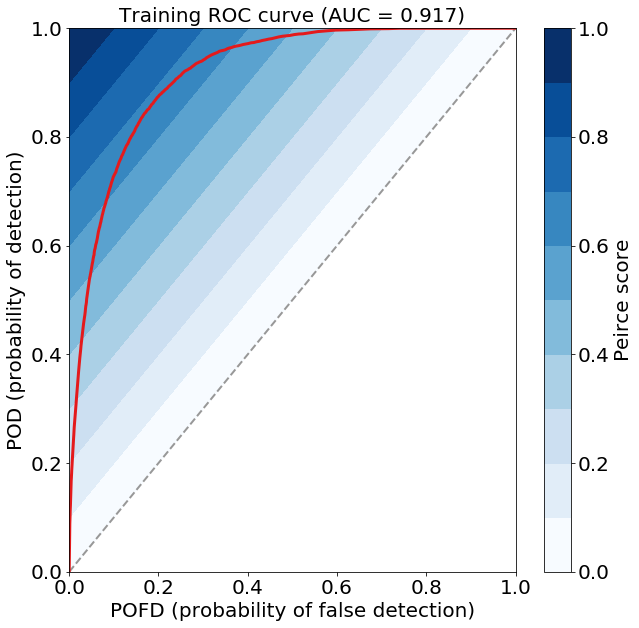

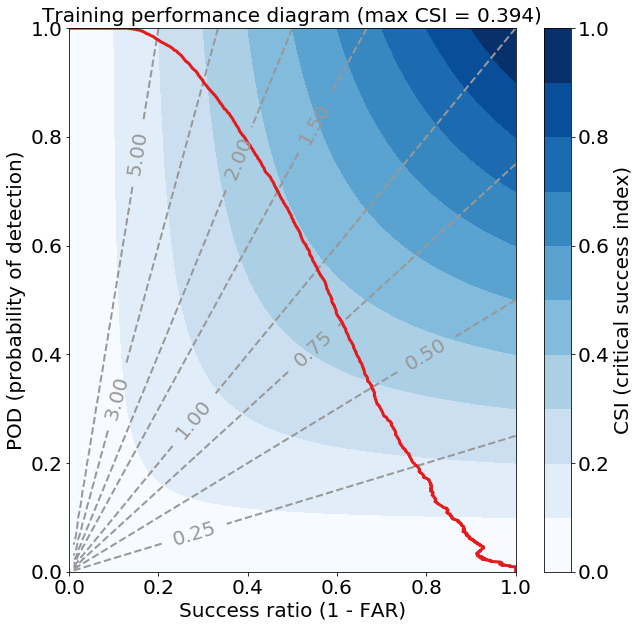

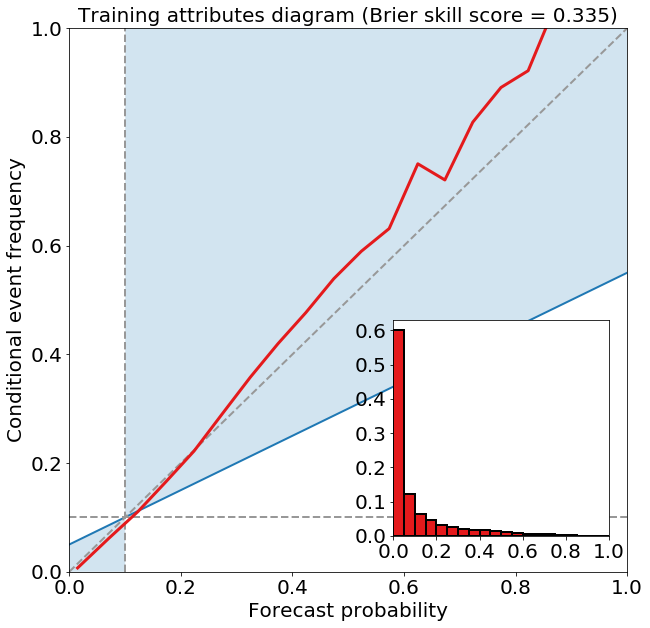

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Validation Max Peirce score (POD - POFD) = 0.670
Validation AUC (area under ROC curve) = 0.913
Validation Max CSI (critical success index) = 0.401
Validation Brier score = 0.061
Validation Brier skill score (improvement over climatology) = 0.328


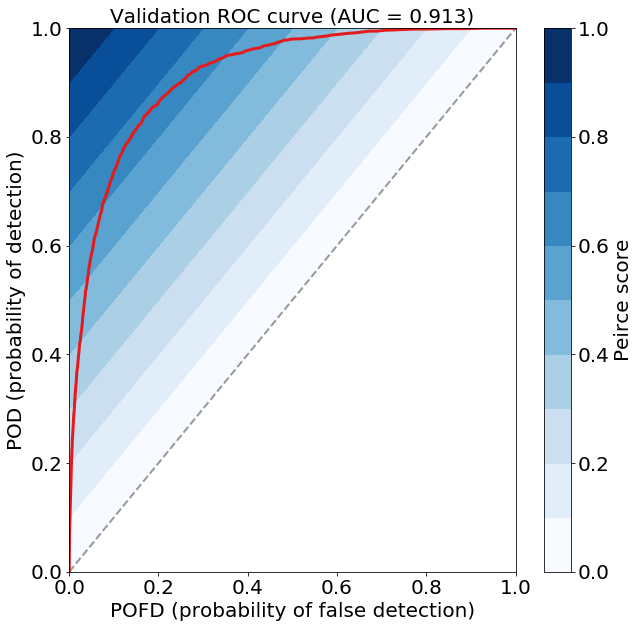

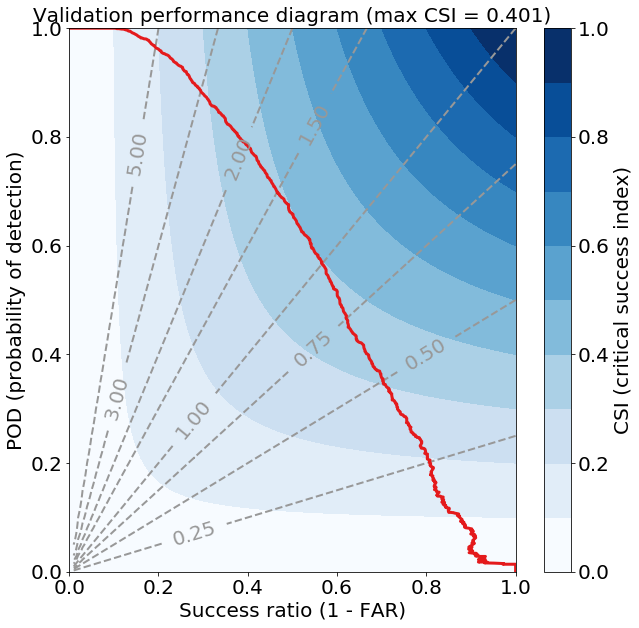

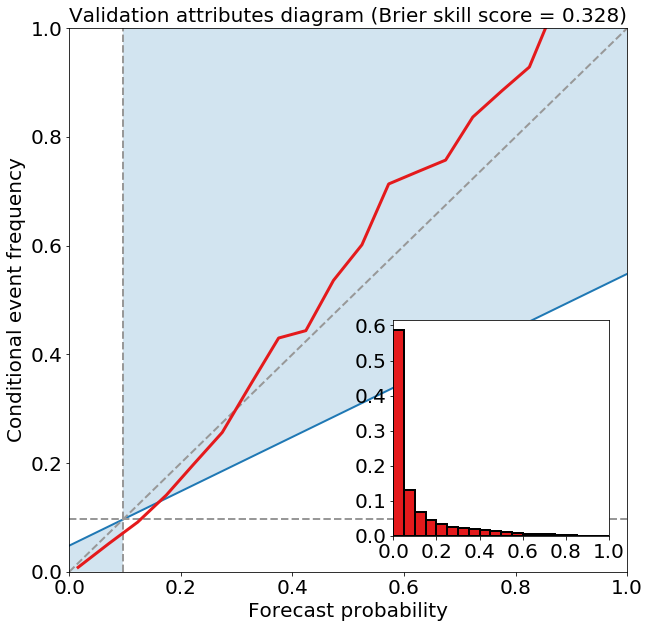

{'max_peirce_score': 0.6695651841996653,
 'area_under_roc_curve': 0.9134534233100869,
 'max_csi': 0.4013440860215054,
 'brier_score': 0.06069343762819473,
 'brier_skill_score': 0.32768543236817277}

In [36]:
num_predictors = len(list(training_predictor_table))
max_predictors_per_split = int(numpy.round(
    numpy.sqrt(num_predictors)
))

random_forest_model_object = utils.setup_classification_forest(
    max_predictors_per_split=max_predictors_per_split,
    min_examples_at_split=500, min_examples_at_leaf=200)

_ = utils.train_classification_forest(
    model_object=random_forest_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = random_forest_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = random_forest_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Gradient-boosted Trees

 - Gradient-boosting is another way to ensemble decision trees.
 - In a random forest the trees are trained independently of each other.
 - In a gradient-boosted ensemble (or "gradient-boosted forest"), the $k^{\textrm{th}}$ tree is trained to fit residuals from the first $k$ - 1 trees.
 - The "residual" for the $i^{\textrm{th}}$ example is $y_i - p_i$.
<br><br>
 - Gradient-boosted trees can still use example-bagging and predictor-bagging.
 - However, in most libraries the default is no example-bagging or predictor-bagging (train each tree with all examples and attempt all predictors at each branch node).
<br><br>
 - In a random forest the trees can be trained in parallel (each tree is independent of the others), which makes random forests faster.
 - In a gradient-boosted ensemble the trees must be trained in series, which makes them slower.
 - However, in practice gradient-boosting usually outperforms random forests.
 - In a recent contest for solar-energy prediction, the top 3 teams all used gradient-boosted trees (McGovern *et al*. 2015).

# Gradient-boosted Trees: Example

The next cell trains a gradient-boosted ensemble with the following hyperparameters:

 - No example-bagging
 - No predictor-bagging
 - 100 trees
 - Minimum of 500 examples at a branch node
 - Minimum of 200 examples at a leaf node

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


Training Max Peirce score (POD - POFD) = 0.681
Training AUC (area under ROC curve) = 0.920
Training Max CSI (critical success index) = 0.399
Training Brier score = 0.059
Training Brier skill score (improvement over climatology) = 0.347


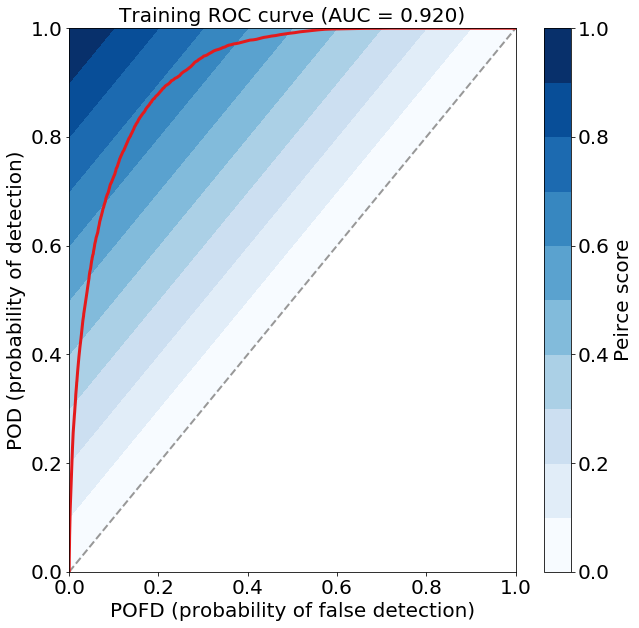

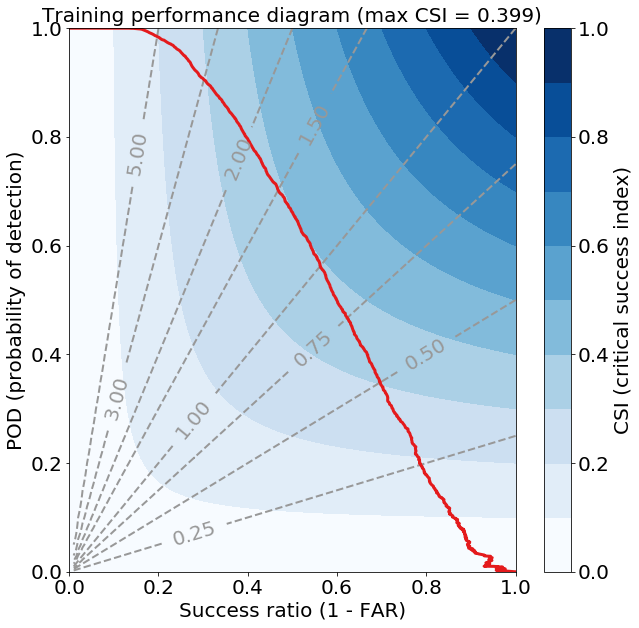

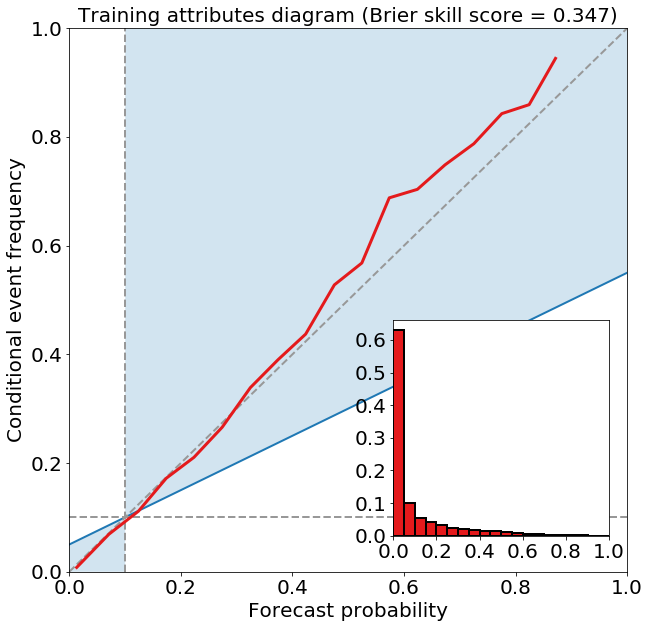

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Validation Max Peirce score (POD - POFD) = 0.665
Validation AUC (area under ROC curve) = 0.912
Validation Max CSI (critical success index) = 0.398
Validation Brier score = 0.061
Validation Brier skill score (improvement over climatology) = 0.325


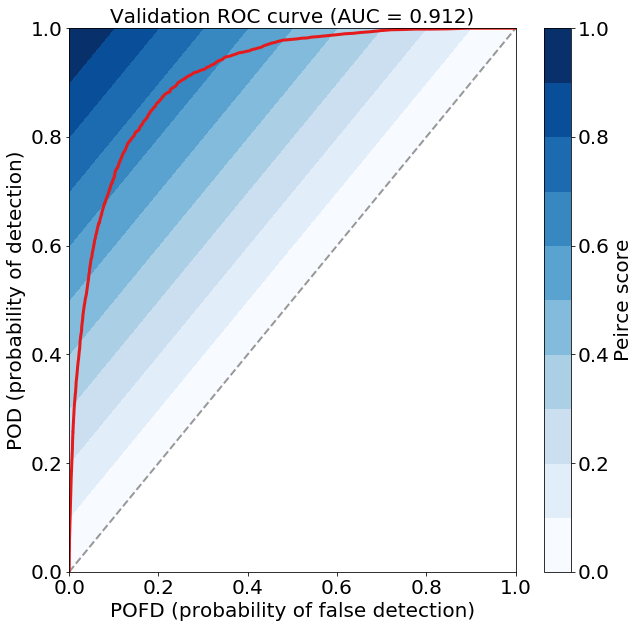

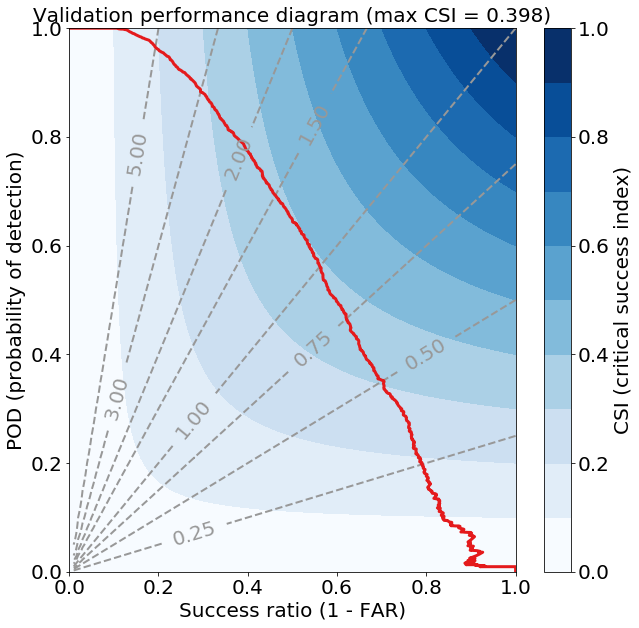

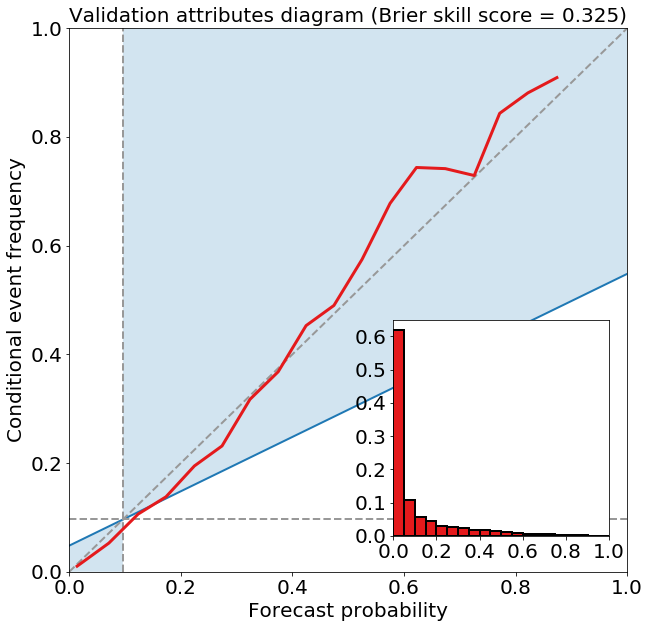

{'max_peirce_score': 0.665479294198189,
 'area_under_roc_curve': 0.9120365974797522,
 'max_csi': 0.3978121664887941,
 'brier_score': 0.06089091911392852,
 'brier_skill_score': 0.32549788648372735}

In [37]:
num_predictors = len(list(training_predictor_table))

gbt_model_object = utils.setup_classification_forest(
    max_predictors_per_split=num_predictors,
    min_examples_at_split=500, min_examples_at_leaf=200)

_ = utils.train_classification_gbt(
    model_object=gbt_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = gbt_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = gbt_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')